# Project Luther

#### Purpose:
Using information we scrape from the web, build linear regression models from which we can learn about movies / sports / other categories

#### Data:
Acquisition: scraping  
Storage: flat files  
Sources: boxofficemojo.com; imdb.com; pcpartpicker.com; All_GPUs.csv (from Kaggle.com)

#### Skills:
- Basics of the web (HTML, Javascript)
- web scraping
- numpy and pandas
- statsmodel, scikit-learn

### Complete the following form prior to starting analysis:

#### Question / need:
- What is the linear regression of:
  * GPU price vs. memory
  * GPU price vs. rating
  * GPU price vs clock speed
  * gpuboss rating vs. all other parameters / GPU specifications
- price distribution per chipset
- brand impact on price

#### Description of my sample data:
- Table of different GPUs, their affiliated chipset, memory, core clock, rating, and other specifications

#### Characteristics of each entry:
- Each entry is based on a pre-defined chipset (Nvidia vs. AMD)
- Each entry provides at least: categorical values (e.g. manufacturer; chipset), clock speed, and memory


#### First import all the libraries we will need for analysis

In [96]:
import numpy as np
import pandas as pd

from __future__ import print_function, division

import requests

from bs4 import BeautifulSoup
import re # for regex; e.g. text=re.compile('inserttexthere')

In [155]:
# define url(s) and pull from the web; assign to variable 'response'
url = 'https://pcpartpicker.com/products/video-card/detailed-list/#page=1'

response = requests.get(url)

In [156]:
# check status code
response.status_code # 200 - means requests is good

200

In [157]:
# prettify the HTML code to library BeautifulSoup
page = response.text
soup = BeautifulSoup(page,"lxml") # xml is generally what you use for HTML parsing
# soup = BeautifulSoup(page,"html.parser")

In [158]:
# check out HTML text
print(soup.prettify())

<!DOCTYPE html>
<html>
 <head>
  <meta charset="utf-8"/>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <script type="text/javascript">
   window.NREUM||(NREUM={}),__nr_require=function(e,t,n){function r(n){if(!t[n]){var o=t[n]={exports:{}};e[n][0].call(o.exports,function(t){var o=e[n][1][t];return r(o||t)},o,o.exports)}return t[n].exports}if("function"==typeof __nr_require)return __nr_require;for(var o=0;o<n.length;o++)r(n[o]);return r}({1:[function(e,t,n){function r(){}function o(e,t,n){return function(){return i(e,[f.now()].concat(u(arguments)),t?null:this,n),t?void 0:this}}var i=e("handle"),a=e(2),u=e(3),c=e("ee").get("tracer"),f=e("loader"),s=NREUM;"undefined"==typeof window.newrelic&&(newrelic=s);var p=["setPageViewName","setCustomAttribute","setErrorHandler","finished","addToTrace","inlineHit","addRelease"],d="api-",l=d+"ixn-";a(p,function(e,t){s[t]=o(d+t,!0,"api")}),s.addPageAction=o(d+"

In [162]:
# code to get the title of a film
catalog = soup.find('tbody', id='category_content')
catalog

<tbody id="category_content">
</tbody>

### It appears the HTML pulled with 'requests' library does not contain all the information we need; we will need to refer to selerium

In [1475]:
# using selerium

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
#import time
from time import sleep, time
from random import randint
from IPython.core.display import clear_output
from warnings import warn

import os
chromedriver = "/Users/auyeus/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

#driver = webdriver.Chrome(chromedriver)
#driver.get(url)

### Helper functions for scraping data from pcpartpicker.com

In [504]:
# pulling Video Card info
def get_gpu_info(gpu_index):
    '''
    input: GPU index
    output: appends gpu name, series, chipset, memory, core clock, rating count, and price
            to associated lists
    '''
    
    # pulling video card name
    video_name_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[@class='tdname']"
    name = driver.find_element_by_xpath(video_name_selector).text
    gpu_name_list.append(name)
    
    # pulling gpu series name
    gpu_series_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[3]"
    series = driver.find_element_by_xpath(gpu_series_selector).text
    series_list.append(series)

    # pulling chipset name
    chipset_name_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[@style='white-space:nowrap;']"
    chipset = driver.find_element_by_xpath(chipset_name_selector).text
    chipset_list.append(chipset)

    # pulling video card memory
    memory_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[@style='text-align:right;']"
    memory = driver.find_element_by_xpath(memory_selector).text
    memory_list.append(memory)

    # pulling core clock
    core_clock_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[@style='white-space:nowrap;text-align:right;']"
    core_clock = driver.find_element_by_xpath(core_clock_selector).text
    core_clock_list.append(core_clock)

    # pulling ratings total count
    ratings_count_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[@class='inline-rating-sm']"
    ratings_count = driver.find_element_by_xpath(ratings_count_selector).text
    rating_count_list.append(ratings_count)

    # pulling price
    price_selector = "//tbody[@id='category_content']/tr["+str(gpu_index)+"]/td[@class='tdprice']"
    price = driver.find_element_by_xpath(price_selector).text
    price_list.append(price)

In [525]:
# need a separate script for pulling rating (stars)

def get_gpu_rating(gpu_index):
    '''
    input: GPU index
    output: returns GPU rating as a float
    '''
    #variable to track gpu rating
    gpu_rating = 0.0
    
    # iterate through each gpu rating
    gpu_stars = all_gpu_ratings[gpu_index].find_all('li')
    
    # for loop to get gpu_rating
    for star in gpu_stars:
        if star.attrs['class'] == ['full-star']:
            gpu_rating += 1
        elif star.attrs['class'] == ['half-star']:
            gpu_rating += 0.5
    
    return gpu_rating

## Script to scrape pcpartpicker.com

In [522]:
# script for multiple webpages on 'pcpartpicker.com'

# start Selenium
url = 'https://pcpartpicker.com/products/video-card/detailed-list/#page=1'
driver = webdriver.Chrome(chromedriver)
driver.get(url)

# lists to store scraped data in
gpu_name_list = []
series_list = []
chipset_list = []
memory_list = []
core_clock_list = []
rating_list = []
rating_count_list = []
price_list = []

# monitoring of loop
start_time = time()
requests = 0 # used to count number of requests

# allow webpage to load for 5 seconds
sleep(5)

# get list of pages from webpage
page_selector = "//div[@id='page_button_row_bot']/div[@class='page-button-row']/div[@class='page-button']"
last_page = int(driver.find_elements_by_xpath(page_selector)[-1].text)
pages = [str(i) for i in range(1,last_page+1)]

# for every page available
for page in pages:
    
    # make a request to webpage
    url = 'https://pcpartpicker.com/products/video-card/detailed-list/#page=' + page
    driver.get(url)
    
    # pause the loop
    sleep(randint(8,15))
    
    # pulling list of video cards on webpage and seeing how many there are
    gpu_list_selector = "//tbody[@id='category_content']/tr" # xpath to gpu table
    gpu_container = driver.find_elements_by_xpath(gpu_list_selector) # create list of all GPUs from webpage table
    #len(gpu_container) # total GPUs in webpage table
    
    # monitor the requests
    requests += 1
    elapsed_time = time() - start_time
    print('Request: {}; Frequency: {} requests/s'.format(requests,requests/elapsed_time))
    clear_output(wait=True)
    
    
    # Break the loop if number of requests greater than expected
    if requests > len(pages):
        warn('Number of requests was greater than expected.')
        break
        
    # parse the content of the request with BeautifulSoup
    soup = BeautifulSoup(driver.page_source,"html.parser") # mixing selenium + BeautifulSoup
    
    # refer to website's table of GPUs and finds all tags related to GPU rating; put in list
    all_gpu_ratings = soup.find('tbody',id='category_content').find_all('ul',class_='stars')
    
    
    # Scrap the GPU info
    for gpu in range(len(gpu_container)):
        get_gpu_info((gpu+1)) # gets gpu info, except rating score
        rating_list.append(get_gpu_rating(gpu)) # gets gpu rating score

# message once scraping is complete
print('scraping done')

# close selenium driver
driver.close()

Request: 36; Frequency: 0.029787804881967854 requests/s


## Script to scrape gpuboss.com

### Functions below for grabbing GPU specs and benchmarks from GPUBoss.com

In [1455]:
# attempt to pull gpuboss review score
def get_gpuboss_score():
    try: output = soup.find(class_='score-text').text
    except: output = 'N/A'
    return output

# grab specific gpu spec
def get_gpu_spec(table_row_id):
    try: output = soup.find('tr',{'id':table_row_id}).find(class_='formatted-value some-value').text
    except: output = 'N/A'
    return output

# capture benchmark scores for:
# 'Manhattan (GFXBench 3.0)'
# 'T-Rex (GFXBench 3.0)'
def get_gpu_benchmark(benchmark,benchmark_list):
    try: 
        index_num = benchmark_list.index(benchmark)
        output = soup.find('div',{'id':'performance'}).find_all('div',{'href':'product-url'})[index_num].findNextSibling().text
    except: output = 'N/A'
    return output

### Script for Scraping website GPUBOSS

In [ ]:
# start Selenium
url = 'http://gpuboss.com/gpus/Graphics-cards-best-PassMark-score-5825384'
driver = webdriver.Chrome(chromedriver)
driver.get(url)

# lists to store scraped data in (from main page)
release_dates = []
passmark_scores = []
manufacturers_list = []
model_list = []
dual_gpu_list = []
gpu_url_list = []
benchmark_list = []

# list of features to capture from each gpu webpage
gpuboss_scores = []
t_rex_gfx_scores = []
manhattan_gfx_scores = []
market_list = []
clock_speeds = []
turbo_clock_speeds = []
shading_units = []
texture_mapping_units = []
render_output_processors = []
pixel_rates = []
texture_rates = []
floating_point_performances = []
memory_clock_speeds = []
effective_memory_clock_speeds = []
memory_bus_list = []
memory_list_total = []
memory_type_list = []
memory_bandwidth_list = []
tdp_list = []

# monitoring of loop through main page
start_time = time()
requests = 0 # used to count number of requests for scrolling down gpuboss webpage

# allow webpage to load for 5 seconds
sleep(5)

'''SCROLL THROUGH ENTIRE WEBPAGE'''
# Get initial webpage scroll height
last_height = driver.execute_script("return document.body.scrollHeight")

while True:
    # Scroll down to bottom
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

    # pause the loop
    sleep(randint(2,5))
    
    # monitor the scroll requests
    requests += 1
    elapsed_time = time() - start_time
    print('Request: {}; Frequency: {} requests/s'.format(requests,requests/elapsed_time))
    clear_output(wait=True)
        
    # Calculate new scroll height and compare with last scroll height
    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        break # once we hit the bottom of the page, get out of loop
    last_height = new_height

''' scrape high-level gpu specs from main page'''
# parse the HTML of the request with BeautifulSoup
soup = BeautifulSoup(driver.page_source,"lxml") # mixing selenium + BeautifulSoup

# append all release dates to release_date list
for date in soup.find_all(class_='date'):
    release_dates.append(date.text)

# append all manufacturer results to manufacturer list
for manufacturer in soup.find_all(class_='product-label product'):
    manufacturers_list.append(manufacturer.find(class_='mfg').text)

# append all model results to model list
for model in soup.find_all(class_='product-label product'):
    model_list.append(model.find(class_='model').text)
    
# append all passmark scores to passmark_score list
for score in soup.find_all(id='value_passmark'):
    passmark_scores.append(score.find(class_='mobile-none').text)
    
# append all dual gpu indicators to list
for dual_gpu in soup.find_all(id='value_dual-gpu'):
    dual_gpu_list.append(dual_gpu.find(class_='mobile-none').text)
    
# append each GPU url to a list (for scraping)  
for gpu_url in soup.find_all(class_='rank-title'):
    gpu_url_list.append(gpu_url.find('a')['href'])

''' SCRAPE EACH GPU WEBPAGE '''
# monitor gpu spec requests
start_time_gpu = time()
requests_gpu = 0 # used to count number of requests from individual gpu webpages

# Scrap each GPU's info    
for gpu_url in gpu_url_list:
    driver.get('http://gpuboss.com'+gpu_url)
    
    # pause the loop
    sleep(randint(5,8))
    
    # monitor the scroll requests
    requests_gpu += 1
    elapsed_time = time() - start_time_gpu
    print('Request: {}; Frequency: {} requests/s'.format(requests_gpu,requests_gpu/elapsed_time))
    clear_output(wait=True)
    
    # Break the loop if number of requests greater than expected
    if requests_gpu > len(gpu_url_list):
        warn('Number of requests was greater than expected.')
        break

     # parse each individual gpu's requested webpage HTML with BeautifulSoup
    soup = BeautifulSoup(driver.page_source,'lxml')
    
    '''gather GPU specifications and append to associated lists'''
    # append gpuboss score to list
    gpuboss_scores.append(get_gpuboss_score())
    
    # capture benchmark scores (e.g. bitcoin mining; face detection)
    benchmark_list = [x.text for x in soup.find('div',{'id':'performance'}).find_all(class_='feature-title')]
    t_rex_gfx_scores.append(get_gpu_benchmark('T-Rex (GFXBench 3.0)',benchmark_list))
    manhattan_gfx_scores.append(get_gpu_benchmark('Manhattan (GFXBench 3.0)',benchmark_list))
    
    # capture gpu specifications
    market_list.append(get_gpu_spec('prop_market'))
    clock_speeds.append(get_gpu_spec('prop_clock_speed'))
    turbo_clock_speeds.append(get_gpu_spec('prop_turbo_clock_speed'))
    shading_units.append(get_gpu_spec('prop_shading_units'))
    texture_mapping_units.append(get_gpu_spec('prop_texture_mapping_units'))
    render_output_processors.append(get_gpu_spec('prop_render_output_processors'))
    pixel_rates.append(get_gpu_spec('prop_pixel_rate'))
    texture_rates.append(get_gpu_spec('prop_texture_rate'))
    floating_point_performances.append(get_gpu_spec('prop_floating_point_performance'))
    memory_clock_speeds.append(get_gpu_spec('prop_memory_clock_speed'))
    effective_memory_clock_speeds.append(get_gpu_spec('prop_memory_effective_clock_speed'))
    memory_bus_list.append(get_gpu_spec('prop_memory_bus_width'))
    memory_list_total.append(get_gpu_spec('prop_memory_size'))
    memory_type_list.append(get_gpu_spec('prop_memory_type'))
    memory_bandwidth_list.append(get_gpu_spec('prop_memory_bandwidth'))
    tdp_list.append(get_gpu_spec('prop_tdp'))


# message once scraping is complete
print('scraping done')

# close selenium driver
driver.close()

## Use below code to continue scraping

In [ ]:
import os
chromedriver = "/Users/auyeus/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver
driver = webdriver.Chrome(chromedriver)

''' SCRAPE EACH GPU WEBPAGE '''
# monitor gpu spec requests
start_time_gpu = time()
requests_gpu = 0 # used to count number of requests from individual gpu webpages

# Scrap each GPU's info    
for gpu_url in gpu_url_list[480:]:
    driver.get('http://gpuboss.com'+gpu_url)
    
    # pause the loop
    sleep(randint(5,8))
    
    # monitor the scroll requests
    requests_gpu += 1
    elapsed_time = time() - start_time_gpu
    print('Request: {}; Frequency: {} requests/s'.format(requests_gpu,requests_gpu/elapsed_time))
    clear_output(wait=True)
    
    # Break the loop if number of requests greater than expected
    if requests_gpu > len(gpu_url_list):
        warn('Number of requests was greater than expected.')
        break

     # parse each individual gpu's requested webpage HTML with BeautifulSoup
    soup = BeautifulSoup(driver.page_source,'lxml')
    
    '''gather GPU specifications and append to associated lists'''
    # append gpuboss score to list
    gpuboss_scores.append(get_gpuboss_score())
    
    # capture benchmark scores (e.g. bitcoin mining; face detection)
    benchmark_list = [x.text for x in soup.find('div',{'id':'performance'}).find_all(class_='feature-title')]
    t_rex_gfx_scores.append(get_gpu_benchmark('T-Rex (GFXBench 3.0)',benchmark_list))
    manhattan_gfx_scores.append(get_gpu_benchmark('Manhattan (GFXBench 3.0)',benchmark_list))
    
    # capture gpu specifications
    market_list.append(get_gpu_spec('prop_market'))
    clock_speeds.append(get_gpu_spec('prop_clock_speed'))
    turbo_clock_speeds.append(get_gpu_spec('prop_turbo_clock_speed'))
    shading_units.append(get_gpu_spec('prop_shading_units'))
    texture_mapping_units.append(get_gpu_spec('prop_texture_mapping_units'))
    render_output_processors.append(get_gpu_spec('prop_render_output_processors'))
    pixel_rates.append(get_gpu_spec('prop_pixel_rate'))
    texture_rates.append(get_gpu_spec('prop_texture_rate'))
    floating_point_performances.append(get_gpu_spec('prop_floating_point_performance'))
    memory_clock_speeds.append(get_gpu_spec('prop_memory_clock_speed'))
    effective_memory_clock_speeds.append(get_gpu_spec('prop_memory_effective_clock_speed'))
    memory_bus_list.append(get_gpu_spec('prop_memory_bus_width'))
    memory_list_total.append(get_gpu_spec('prop_memory_size'))
    memory_type_list.append(get_gpu_spec('prop_memory_type'))
    memory_bandwidth_list.append(get_gpu_spec('prop_memory_bandwidth'))
    tdp_list.append(get_gpu_spec('prop_tdp'))


# message once scraping is complete
print('scraping done')

# close selenium driver
driver.close()

### Check specific GPU results are right (compare against website)

In [1433]:
# check results of a specified-GPU
def check_outcome(gpu_index):
    print('Manufacturer:',manufacturers_list[gpu_index])
    print('chipset:',model_list[gpu_index])
    print('Release Date:',release_dates[gpu_index])
    print('GPUBoss Score:',gpuboss_scores[gpu_index])
    print('T-Rex GFX Score:',t_rex_gfx_scores[gpu_index])
    print('Manhattan GFX Score:',manhattan_gfx_scores[gpu_index])
    print('Market:',market_list[gpu_index])
    print('Clock Speed:',clock_speeds[gpu_index])
    print('Turbo Clock Speed:',turbo_clock_speeds[gpu_index])
    print('Shading units:',shading_units[gpu_index])
    print('Texture mapping units:',texture_mapping_units[gpu_index])
    print('Render output processors:',render_output_processors[gpu_index])
    print('Pixel Rate:',pixel_rates[gpu_index])
    print('Texture Rate:',texture_rates[gpu_index])
    print('Floating-point performance:',floating_point_performances[gpu_index])
    print('Memory clock speed:',memory_clock_speeds[gpu_index])
    print('Effective memory clock speed:',effective_memory_clock_speeds[gpu_index])
    print('Memory bus:',memory_bus_list[gpu_index])
    print('Memory:',memory_list_total[gpu_index])
    print('Memory Type:',memory_type_list[gpu_index])
    print('Memory bandwidth:',memory_bandwidth_list[gpu_index])
    print('TDP:',tdp_list[gpu_index])

In [1917]:
check_outcome(473)

Manufacturer: Sapphire
chipset: Radeon R9 270 1024SP
Release Date: Released March, 2015
GPUBoss Score: N/A
T-Rex GFX Score: N/A
Manhattan GFX Score: N/A
Market: Desktop
Clock Speed: 900 MHz
Turbo Clock Speed: 930 MHz
Shading units: 1,024
Texture mapping units: 64
Render output processors: 32
Pixel Rate: 29.76 GPixel/s
Texture Rate: 59.5 GTexel/s
Floating-point performance: 1,904.6 GFLOPS
Memory clock speed: 1,200 MHz
Effective memory clock speed: 4,800 MHz
Memory bus: 256 bit
Memory: 2,048 MB
Memory Type: GDDR5
Memory bandwidth: 153.6 GB/s
TDP: 150W


## Store scraped data into DataFrame and pickle

### for pcpartpicker website

In [ ]:
# check to see if data collected successfully with Pandas
test_df = pd.DataFrame({'GPU_Name':gpu_name_list,
                        'Series':series_list,
                        'Chipset':chipset_list,
                        'Memory':memory_list,
                        'Core_Clock':core_clock_list,
                        'Rating':rating_list,
                        'Rating_Count':rating_count_list,
                        'Price':price_list})

print(test_df.info())
test_df.head(10)

### Store GPUBoss data into DataFrame and pickle

In [1959]:
release_dates_temp = release_dates[0:474]
manufacturers_list_temp = manufacturers_list[0:474]
model_list_temp = model_list[0:474]
dual_gpu_list_temp = dual_gpu_list[0:474]
passmark_scores_temp = passmark_scores[0:474]

In [2016]:
# check to see if data collected successfully with Pandas
gpuboss_df = pd.DataFrame({'release_date':release_dates_temp,
                           'manufacturer':manufacturers_list_temp,
                           'chipset':model_list_temp,
                           'dual_gpu':dual_gpu_list_temp,
                           'passmark_score':passmark_scores_temp,
                           'gpuboss_score':gpuboss_scores,
                           't_rex_gfx_score':t_rex_gfx_scores,
                           'manhattan_gfx_score':manhattan_gfx_scores,
                           'market':market_list,
                           'clock_speed':clock_speeds,
                           'turbo_clock_speed':turbo_clock_speeds,
                           'shading_units':shading_units,
                           'texture_mapping_units':texture_mapping_units,
                           'render_output_processors':render_output_processors,
                           'pixel_rate':pixel_rates,
                           'texture_rate':texture_rates,
                           'floating_point_performance':floating_point_performances,
                           'memory_clock_speed':memory_clock_speeds,
                           'effective_memory_clock_speed':effective_memory_clock_speeds,
                           'memory_bus':memory_bus_list,
                           'memory':memory_list_total,
                           'memory_type':memory_type_list,
                           'memory_bandwidth':memory_bandwidth_list,
                           'tdp':tdp_list})

print(gpuboss_df.info())
gpuboss_df.head(5)
#gpuboss_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 24 columns):
release_date                    474 non-null object
manufacturer                    474 non-null object
chipset                         474 non-null object
dual_gpu                        474 non-null object
passmark_score                  474 non-null object
gpuboss_score                   474 non-null object
t_rex_gfx_score                 474 non-null object
manhattan_gfx_score             474 non-null object
market                          474 non-null object
clock_speed                     474 non-null object
turbo_clock_speed               474 non-null object
shading_units                   474 non-null object
texture_mapping_units           474 non-null object
render_output_processors        474 non-null object
pixel_rate                      474 non-null object
texture_rate                    474 non-null object
floating_point_performance      474 non-null object
memory_cloc

,release_date,manufacturer,chipset,dual_gpu,passmark_score,gpuboss_score,t_rex_gfx_score,manhattan_gfx_score,market,clock_speed,...,pixel_rate,texture_rate,floating_point_performance,memory_clock_speed,effective_memory_clock_speed,memory_bus,memory,memory_type,memory_bandwidth,tdp
0,"Released March, 2017",Nvidia,GeForce GTX 1080 Ti,No,"13,373",8,"8,057.71","8,908.42",N/A,"1,480 MHz",...,139.2 GPixel/s,354.4 GTexel/s,"11,340 GFLOPS","1,376 MHz","11,008 MHz",352 bit,"11,264 MB",GDDR5,484.4 GB/s,250W
1,"Released August, 2016",Nvidia,TITAN X,No,"13,119",9.9,"44,520.41","26,305.73",Desktop,"1,417 MHz",...,136 GPixel/s,N/A,"10,157 GFLOPS","1,251 MHz","10,008 MHz",384 bit,"12,288 MB",GDDR5,N/A,250W
2,"Released May, 2016",Nvidia,GeForce GTX 1080,No,"11,994",9.9,"2,797.35","3,083.3",Desktop,"1,607 MHz",...,102.8 GPixel/s,257.1 GTexel/s,"8,228 GFLOPS","1,251 MHz","10,008 MHz",256 bit,"8,192 MB",GDDR5,224.4 GB/s,180W
3,"Released June, 2015",Nvidia,GeForce GTX 980 Ti,No,"11,318",8.7,"63,092.87","3,708.09",Desktop,"1,000 MHz",...,96 GPixel/s,176 GTexel/s,"5,632 GFLOPS","1,753 MHz","7,012 MHz",384 bit,"6,144 MB",GDDR5,N/A,250W
4,"Released June, 2016",Generic,GeForce GTX 1070,No,"11,028",8.5,"3,358.5","3,716.32",Desktop,"1,506 MHz",...,96.4 GPixel/s,180.7 GTexel/s,"5,783 GFLOPS","2,002 MHz","8,008 MHz",256 bit,"8,192 MB",GDDR5,256.3 GB/s,150W


In [1778]:
!rm my_data_2.pkl # remove the pickle file in the working directory

In [2658]:
!ls

Brainstorming_Guide.md
Luther.jpg
Project Luther (#2).ipynb
Project_Scope_Notes_for_Brainstorming.md
README.md
df_train_filled.pkl
my_data.pkl
my_data_2.pkl
my_data_2_updated.pkl
my_data_updated.pkl
template.md


In [1779]:
#data = test_df # for pcpartpicker website
data = gpuboss_df # for gpuboss website

In [1780]:
# pickle the data

from __future__ import print_function
import pickle

# dump panda dataframe into pickle file
with open('my_data_2.pkl','wb') as picklefile:
    pickle.dump(data,picklefile)
    
# my_data.pkl = pcpartpicker
# my_data_2.pkl = gpuboss

In [769]:
# del(data)
# data

In [ ]:
# load pickle file - pcpartpicker website
with open('my_data.pkl','rb') as picklefile:
    df2 = pickle.load(picklefile)

In [2364]:
# load pickle file - GPUBOSS website
with open('my_data_2.pkl','rb') as picklefile:
    df2 = pickle.load(picklefile)

### pcpartpicker dataframe - loaded from pickle my_data.pkl

In [2365]:
df.head(5)

,GPU_Name,Series,Chipset,Memory,Core_Clock,Rating,Rating_Count,Price,Float_Price,Float_Memory_MB,Float_Core_Clock_MHz
0,Asus STRIX-GTX1080TI-11G-GAMING,STRIX GAMING,GeForce GTX 1080 Ti,11GB,1.49GHz,5.0,21,$809.99,809.99,11000.0,1490
1,EVGA 06G-P4-6163-KR,SC GAMING,GeForce GTX 1060 6GB,6GB,1.61GHz,4.5,56,$254.98,254.98,6000.0,1610
2,MSI GTX 1050 Ti GAMING X 4G,GAMING X 4G,GeForce GTX 1050 Ti,4GB,1.29GHz,4.5,17,$189.98,189.98,4000.0,1290
3,MSI GeForce GTX 1060 6GT OCV1,GT OCV1,GeForce GTX 1060 6GB,6GB,1.54GHz,4.5,13,$264.98,264.98,6000.0,1540
4,EVGA 08G-P4-5173-KR,SC GAMING ACX 3.0 Black Edition,GeForce GTX 1070,8GB,1.59GHz,4.5,38,$364.98,364.98,8000.0,1590


### gpu boss dataframe - loaded from pickle my_data_2.pkl

In [2256]:
df2.tail(5)

,release_date,manufacturer,chipset,dual_gpu,passmark_score,gpuboss_score,t_rex_gfx_score,manhattan_gfx_score,market,clock_speed,...,pixel_rate,texture_rate,floating_point_performance,memory_clock_speed,effective_memory_clock_speed,memory_bus,memory,memory_type,memory_bandwidth,tdp
469,"Released February, 2008",Nvidia,GeForce 9300M G,No,85,N/A,N/A,N/A,Laptop,400 MHz,...,1.6 GPixel/s,3.2 GTexel/s,25.6 GFLOPS,600 MHz,"1,200 MHz",64 bit,256 MB,GDDR3,9.6 GB/s,13W
470,"Released October, 2008",Nvidia,GeForce 9200M,No,81,5.6,913.96,N/A,N/A,450 MHz,...,1.8 GPixel/s,3.6 GTexel/s,38.4 GFLOPS,N/A,N/A,N/A,N/A,N/A,N/A,12W
471,"Released July, 2008",ATi,Mobility Radeon HD 3410,No,62,N/A,N/A,N/A,Laptop,400 MHz,...,1.6 GPixel/s,1.6 GTexel/s,32 GFLOPS,400 MHz,800 MHz,64 bit,256 MB,DDR2,6.4 GB/s,7W
472,"Released January, 2008",ATi,Radeon X1050,No,49,N/A,N/A,N/A,Desktop,400 MHz,...,3.2 GPixel/s,3.2 GTexel/s,N/A,200 MHz,400 MHz,64 bit,128 MB,N/A,3.2 GB/s,24W
473,"Released March, 2015",Sapphire,Radeon R9 270 1024SP,No,,N/A,N/A,N/A,Desktop,900 MHz,...,29.76 GPixel/s,59.5 GTexel/s,"1,904.6 GFLOPS","1,200 MHz","4,800 MHz",256 bit,"2,048 MB",GDDR5,153.6 GB/s,150W


# Clean the Data

### Clean pcpartpicker data
Things to do:
- change Price column to float
- check ratings column to ensure there are no extremes
- normalize rating to generate histogram

In [1010]:
# for rows where 'Price' is blank, update to 'N/A'
df.loc[df['Price']=='','Price'] = df['Price'].str.replace('','N/A')

# create a new column 'Float Price' for numerical analysis
df['Float_Price'] = df.loc[:,'Price']

# update column 'float price' by removing the '$' string and replacing 'N/A' with '0.0'
df.loc[:,'Float_Price'] = df['Float_Price'].str.replace('$','')
df.loc[df['Float_Price'] == 'N/A','Float_Price'] = df['Float_Price'].str.replace('N/A','0.0')

# set column 'Float Price' as a float data type
df.loc[:,'Float_Price'] = df['Float_Price'].astype(float)

# set column 'Rating Count' as an int data type for numerical analysis
df.loc[:,'Rating_Count'] = df['Rating_Count'].str.replace('(','')
df.loc[:,'Rating_Count'] = df['Rating_Count'].str.replace(')','').astype(int)

# ceate a new column 'Float Memory'
df['Float_Memory_MB'] = df.loc[:,'Memory']

# update column 'Float Memory (MB)' - remove string and change data type to float; normalize from GB to MB
df.loc[(df['Float_Memory_MB'].str.len()==4) & (df['Float_Memory_MB'].str.contains('GB')),['Float_Memory_MB']] = df['Float_Memory_MB'].str.replace('GB','000')
df.loc[(df['Float_Memory_MB'].str.len()==3) & (df['Float_Memory_MB'].str.contains('GB')),['Float_Memory_MB']] = df['Float_Memory_MB'].str.replace('GB','000')
df.loc[(df['Float_Memory_MB'].str.len()==5) & (df['Float_Memory_MB'].str.contains('GB')),['Float_Memory_MB']] = df['Float_Memory_MB'].str.replace('GB','00')
df.loc[(df['Float_Memory_MB'].str.len()==6) & (df['Float_Memory_MB'].str.contains('GB')),['Float_Memory_MB']] = df['Float_Memory_MB'].str.replace('GB','0')
df.loc[(df['Float_Memory_MB'].str.contains('.')),['Float_Memory_MB']] = df['Float_Memory_MB'].str.replace('.','') # remove periods
df.loc[:,'Float_Memory_MB'] = df['Float_Memory_MB'].str.replace('MB','').astype(float) # remove 'MB' string and set column as float data type

# create a new column 'Float Core Clock (MB)'
df['Float_Core_Clock_MHz'] = df.loc[:,'Core_Clock']

# update column 'Float Core Clock (MB)' - remove string and change data type to int; normalize from GHz to MHz
df.loc[(df['Float_Core_Clock_MHz'].str.len() == 4) & (df['Float_Core_Clock_MHz'].str.contains('GHz')),['Float_Core_Clock_MHz']] = df['Float_Core_Clock_MHz'].str.replace('GHz','000')
df.loc[(df['Float_Core_Clock_MHz'].str.len() == 6) & (df['Float_Core_Clock_MHz'].str.contains('GHz')),['Float_Core_Clock_MHz']] = df['Float_Core_Clock_MHz'].str.replace('GHz','00')
df.loc[(df['Float_Core_Clock_MHz'].str.len() == 7) & (df['Float_Core_Clock_MHz'].str.contains('GHz')),['Float_Core_Clock_MHz']] = df['Float_Core_Clock_MHz'].str.replace('GHz','0')
df.loc[:,'Float_Core_Clock_MHz'] = df['Float_Core_Clock_MHz'].str.replace('.','') # replace periods
df.loc[:,'Float_Core_Clock_MHz'] = df['Float_Core_Clock_MHz'].str.replace('MHz','') # remove MHz
df.loc[:,'Float_Core_Clock_MHz'] = df['Float_Core_Clock_MHz'].str.replace('N/A','0').astype(int) # remove 'N/A' string and set column as int data type


### clean gpuboss data

**things to clean:**
- set release date to MM - YYYY
- set passmark_score as integer / float
- set gpuboss_score as float
- set benchmark scores as float (t_rex + manhattan)
- set clock_speed to integer (normalize to MHz)
- set turbo_clock_speed to integer (normalize to MHz)
- set shading_units to integer
- set texture_mapping_units to integer
- set render_output_processors to integer
- set pixel_rate to float (in GPixel/s units)
- set texture_rate to float (in GTexel/s units)
- set floating_point_performance to float (in GFLOPS units)
- set memory_clock_speed to integer (in MHz units)
- set effective_memory_clock_speed to integer (normalize to MHz)
- set memory_bus to integer 
- set memory to integer (normalize to MB)
- set memory_bandwidth to integer / float (normalize to GB/s)
- set TDP to integer

**set as dummy variables:**
- set manufacturer as dummy variables (tbd)
- set dual_gpu as dummy variables (tbd)
- set market as dummy variables (tbd)
- set memory_type as dummy variables (tbd)

In [2170]:
df2.columns

Index(['release_date', 'manufacturer', 'chipset', 'dual_gpu', 'passmark_score',
       'gpuboss_score', 't_rex_gfx_score', 'manhattan_gfx_score', 'market',
       'clock_speed', 'turbo_clock_speed', 'shading_units',
       'texture_mapping_units', 'render_output_processors', 'pixel_rate',
       'texture_rate', 'floating_point_performance', 'memory_clock_speed',
       'effective_memory_clock_speed', 'memory_bus', 'memory', 'memory_type',
       'memory_bandwidth', 'tdp'],
      dtype='object')

In [2660]:
df2.head(3)

,release_date,manufacturer,chipset,dual_gpu,passmark_score,gpuboss_score,t_rex_gfx_score,manhattan_gfx_score,market,clock_speed_MHz,...,no_dual_gpu,yes_dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
0,2008-01-01,ATi,Radeon X1050,No,49.0,NaN,NaN,NaN,Desktop,400,...,1,0,1,0,0,0,0,0,0,1
1,2008-01-01,ATi,Mobility Radeon HD 3650,No,216.0,NaN,1704.69,NaN,Laptop,500,...,1,0,0,1,0,0,0,1,0,0
2,2008-01-01,Nvidia,GeForce 8800 GS,No,551.0,NaN,NaN,NaN,Desktop,550,...,1,0,1,0,0,0,0,1,0,0


In [2366]:
from datetime import datetime
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

# setting data initially set to 'N/A' (from web-scrape) to NaN

df2.loc[(df2['gpuboss_score']=='N/A'),'gpuboss_score'] = np.nan
df2.loc[(df2['t_rex_gfx_score']=='N/A'),'t_rex_gfx_score'] = np.nan
df2.loc[(df2['manhattan_gfx_score']=='N/A'),'manhattan_gfx_score'] = np.nan
df2.loc[(df2['turbo_clock_speed']=='N/A'),'turbo_clock_speed'] = np.nan
df2.loc[(df2['shading_units']=='N/A'),'shading_units'] = np.nan
df2.loc[(df2['texture_rate']=='N/A'),'texture_rate'] = np.nan
df2.loc[(df2['floating_point_performance']=='N/A'),'floating_point_performance'] = np.nan
df2.loc[(df2['memory_clock_speed']=='N/A'),'memory_clock_speed'] = np.nan
df2.loc[(df2['effective_memory_clock_speed']=='N/A'),'effective_memory_clock_speed'] = np.nan
df2.loc[(df2['memory_bus']=='N/A'),'memory_bus'] = np.nan
df2.loc[(df2['memory']=='N/A'),'memory'] = np.nan
df2.loc[(df2['memory_bandwidth']=='N/A'),'memory_bandwidth'] = np.nan
df2.loc[(df2['tdp']=='N/A'),'tdp'] = np.nan
df2.loc[(df2['passmark_score']==' '),'passmark_score'] = np.nan

# manufacturer column: use sklearn to transform each category (manufacturer) as a column in the DataFrame
manufacturer_data_ = df2['manufacturer'].value_counts()
manufacturer_list_ = [[i] for i in list(df2['manufacturer'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(manufacturer_data_.index)])
one_hot_data_= one_hot.transform(manufacturer_list_)

manufacturer_model_df = pd.DataFrame(one_hot_data_,columns = one_hot.classes_)
df2 = pd.concat([df2, manufacturer_model_df], axis=1, join_axes=[df2.index])

# dual_gpu column: use sklearn to transform each category as a column in the DataFrame
data_ = df2['dual_gpu'].value_counts()
list_ = [[i] for i in list(df2['dual_gpu'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(data_.index)])
one_hot_data_= one_hot.transform(list_)

model_df = pd.DataFrame(one_hot_data_,columns = ['no_dual_gpu','yes_dual_gpu'])
df2 = pd.concat([df2, model_df], axis=1, join_axes=[df2.index])

# market column: use sklearn to transform each category as a column in the DataFrame
market_data_ = df2['market'].value_counts()
market_list_ = [[i] for i in list(df2['market'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(market_data_.index)])
one_hot_data_= one_hot.transform(market_list_)

market_model_df = pd.DataFrame(one_hot_data_,columns = ['desktop_market','laptop_market','undefined_market'])
df2 = pd.concat([df2, market_model_df], axis=1, join_axes=[df2.index])

# memory_type column: use sklearn to transform each category as a column in the DataFrame
memory_type_data_ = df2['memory_type'].value_counts()
memory_type_list_ = [[i] for i in list(df2['memory_type'])]

one_hot = MultiLabelBinarizer()
one_hot.fit([list(memory_type_data_.index)])
one_hot_data_= one_hot.transform(memory_type_list_)

memory_type_model_df = pd.DataFrame(one_hot_data_,columns = ['DDR2_memory','DDR3_memory','GDDR3_memory','GDDR5_memory','undefined_memory'])
df2 = pd.concat([df2, memory_type_model_df], axis=1, join_axes=[df2.index])

# release_date column: update column 'release_date' by removing unnecessary strings and changing to DATETIME data type
df2.loc[:,'release_date'] = df2['release_date'].str.replace('Released ','')
df2.loc[:,'release_date'] = df2['release_date'].str.replace('First seen on ','')
df2.loc[:,'release_date'] = df2['release_date'].str.replace('Expected ','')
df2['release_date'] = pd.to_datetime(df2['release_date'],format='%B, %Y')

# passmark_score column: remove ',' string and set column as integer data type
df2.loc[:,'passmark_score'] = df2['passmark_score'].str.replace(',','').astype(float)

# gpuboss_score column: set column as integer data type
df2.loc[:,'gpuboss_score'] = df2['gpuboss_score'].astype(float) 

# t_rex_gfx_score column: remove ',' string and set column as float data type
df2.loc[:,'t_rex_gfx_score'] = df2['t_rex_gfx_score'].str.replace(',','').astype(float)

# manhattan_gfx_score column: remove ',' string and set column as float data type
df2.loc[:,'manhattan_gfx_score'] = df2['manhattan_gfx_score'].str.replace(',','').astype(float)

# clock_speed column: remove ',' + 'MHz' strings, set column as integer data type, and rename column to 'clock_speed_MHz'
df2.loc[:,'clock_speed'] = df2['clock_speed'].str.replace(',','')
df2.loc[:,'clock_speed'] = df2['clock_speed'].str.replace(' MHz','').astype(int)

# turbo_clock_speed column: remove ',' + 'MHz' strings, set column as integer data type, and rename column to 'turbo_clock_speed_MHz'
df2.loc[:,'turbo_clock_speed'] = df2['turbo_clock_speed'].str.replace(',','')
df2.loc[:,'turbo_clock_speed'] = df2['turbo_clock_speed'].str.replace(' MHz','').astype(float)
# figure out what to do with N/As

# shading_units column: remove ',' string and set column as integer data type
df2.loc[:,'shading_units'] = df2['shading_units'].str.replace(',','').astype(float)
# figure out what to do with N/As

# texture_mapping_units column: set column as integer data type
df2.loc[:,'texture_mapping_units'] = df2['texture_mapping_units'].astype(int)

# render_output_processors column: set column as integer data type
df2.loc[:,'render_output_processors'] = df2['render_output_processors'].astype(int)

# pixel_rate column: remove 'GPixel/s' string, set column as float data type, and rename column to 'pixel_rate_GPixel/s'
df2.loc[:,'pixel_rate'] = df2['pixel_rate'].str.replace(' GPixel/s','').astype(float)

# texture_rate column: remove 'GTexel/s' string, set column as float data type, and rename column to 'texture_rate_GTexel/s'
df2.loc[:,'texture_rate'] = df2['texture_rate'].str.replace(' GTexel/s','').astype(float)
# figure out what to do with N/As

# floating_point_performance column: remove ',' + 'GFLOPS' strings, set column as float data type, and rename to 'floating_point_performance_GFLOPS'
df2.loc[:,'floating_point_performance'] = df2['floating_point_performance'].str.replace(',','')
df2.loc[:,'floating_point_performance'] = df2['floating_point_performance'].str.replace(' GFLOPS','').astype(float)
# figure out what to do with N/As

# memory_clock_speed column: remove ',' + 'MHz' strings, set column as integer data type, and rename to 'memory_clock_speed_MHz'
df2.loc[:,'memory_clock_speed'] = df2['memory_clock_speed'].str.replace(',','')
df2.loc[:,'memory_clock_speed'] = df2['memory_clock_speed'].str.replace(' MHz','').astype(float)
# figure out what to do with N/As

# effective_memory_clock_speed column: remove ',' + 'MHz' strings, set column as integer data type, and rename to 'effective_memory_clock_speed_MHz'
df2.loc[:,'effective_memory_clock_speed'] = df2['effective_memory_clock_speed'].str.replace(',','')
df2.loc[:,'effective_memory_clock_speed'] = df2['effective_memory_clock_speed'].str.replace(' MHz','').astype(float)
# figure out what to do with N/As

# memory_bus column: remove ',' + 'bit' strings, set column as integer data type, and rename to 'memory_bus_bit'
df2.loc[:,'memory_bus'] = df2['memory_bus'].str.replace(',','')
df2.loc[:,'memory_bus'] = df2['memory_bus'].str.replace(' bit','').astype(float)
# figure out what to do with N/As

# memory column: remove ',' + 'bit' strings, set column as integer data type, and rename to 'memory_MB'
df2.loc[:,'memory'] = df2['memory'].str.replace(',','')
df2.loc[:,'memory'] = df2['memory'].str.replace(' MB','').astype(float)
# figure out what to do with N/As

# memory_bandwidth column: remove 'GB/s' string, set column as float data type, and rename to 'memory_bandwidth_GB/s'
df2.loc[:,'memory_bandwidth'] = df2['memory_bandwidth'].str.replace(',','')
df2.loc[:,'memory_bandwidth'] = df2['memory_bandwidth'].str.replace(' GB/s','').astype(float)
# figure out what to do with N/As

# tdp column: remove 'W' string, set column as integer data type, and rename to 'tdp_W'
df2.loc[:,'tdp'] = df2['tdp'].str.replace('W','').astype(float)
# figure out what to do with N/As

# rename columns with measurement units (e.g. GFLOPS)
df2.rename(columns={'memory_bandwidth':'memory_bandwidth_GB/s',
                    'memory':'memory_MB',
                    'memory_bus':'memory_bus_bit',
                    'effective_memory_clock_speed':'effective_memory_clock_speed_MHz',
                    'memory_clock_speed_MHz':'memory_clock_speed_MHz',
                    'floating_point_performance':'floating_point_performance_GFLOPS',
                    'texture_rate':'texture_rate_GTexel/s',
                    'pixel_rate':'pixel_rate_GPixel/s',
                    'turbo_clock_speed':'turbo_clock_speed_MHz',
                    'clock_speed':'clock_speed_MHz',
                    'memory':'memory_MB',
                    'tdp':'tdp_W',
                    'memory_bandwidth':'memory_bandwidth_GB/s'}, inplace=True)

# sort by date; reset index
df2 = df2.sort_values(by=['release_date']).reset_index(drop=True)


### following columns have 'N/A':

- gpuboss_score
- t_rex_gfx_score
- manhattan_gfx_score
- market **(leave this alone - already transforming)**
- turbo_clock_speed
- shading_units
- texture_rate
- floating_point_performance
- memory_clock_speed
- effective_memory_clock_speed
- memory_bus
- memory
- memory_type (categorical)
- memory_bandwidth
- tdp

In [2509]:
df2.loc[df2['passmark_score'].isna()]

,release_date,manufacturer,chipset,dual_gpu,passmark_score,gpuboss_score,t_rex_gfx_score,manhattan_gfx_score,market,clock_speed_MHz,...,no_dual_gpu,yes_dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
392,2015-03-01,Sapphire,Radeon R9 270 1024SP,No,NaN,NaN,NaN,NaN,Desktop,900,...,1,0,1,0,0,0,0,0,1,0


## Check clean data

In [2661]:
# check gpuboss_score column to ensure there are no extremes
df2.describe().loc[['min', 'max'], 'gpuboss_score'] # looks like it is in-line with the rating system (0 to 10)

min    2.8
max    9.9
Name: gpuboss_score, dtype: float64

In [2311]:
df2.describe()

,passmark_score,gpuboss_score,t_rex_gfx_score,manhattan_gfx_score,clock_speed_MHz,turbo_clock_speed_MHz,shading_units,texture_mapping_units,render_output_processors,pixel_rate_GPixel/s,...,no_dual_gpu,dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
count,473.000000,267.000000,301.000000,244.000000,474.000000,150.000000,473.000000,474.000000,474.000000,474.000000,...,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000,474.000000
mean,1867.854123,6.489139,3443.900963,3096.507541,754.611814,1002.593333,650.477801,48.455696,18.080169,14.804283,...,0.959916,0.040084,0.436709,0.500000,0.063291,0.056962,0.267932,0.206751,0.445148,0.023207
std,2343.137541,0.875306,4641.514931,2268.983720,203.884386,220.152391,958.019276,61.785648,18.917477,20.928190,...,0.196364,0.196364,0.496502,0.500528,0.243743,0.232015,0.443350,0.405403,0.497507,0.150719
min,49.000000,2.800000,94.430000,284.470000,300.000000,550.000000,8.000000,4.000000,2.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,443.000000,6.000000,2066.150000,1743.847500,600.000000,855.000000,96.000000,16.000000,8.000000,3.600000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,879.000000,6.300000,3346.570000,3377.340000,725.000000,967.000000,384.000000,32.000000,16.000000,7.380000,...,1.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2217.000000,6.900000,3358.520000,3713.185000,900.000000,1088.250000,720.000000,56.000000,24.000000,16.240000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,13373.000000,9.900000,63092.870000,26305.730000,1607.000000,1759.000000,8192.000000,512.000000,128.000000,139.200000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [2370]:
# new DataFrame with cleaner data
df_updated_2 = df2

# save updated DataFrame with Pickle - dump into new file
with open('my_data_2_updated.pkl','wb') as picklefile:
    pickle.dump(df_updated_2,picklefile)

In [2507]:
!ls

Brainstorming_Guide.md
Luther.jpg
Project Luther (#2).ipynb
Project_Scope_Notes_for_Brainstorming.md
README.md
df_train_filled.pkl
my_data.pkl
my_data_2.pkl
my_data_2_updated.pkl
my_data_updated.pkl
template.md


In [2372]:
# load pickle file
with open('my_data_2_updated.pkl','rb') as picklefile:
    df_updated_2 = pickle.load(picklefile)

In [2373]:
df_updated_2.columns

Index(['release_date', 'manufacturer', 'chipset', 'dual_gpu', 'passmark_score',
       'gpuboss_score', 't_rex_gfx_score', 'manhattan_gfx_score', 'market',
       'clock_speed_MHz', 'turbo_clock_speed_MHz', 'shading_units',
       'texture_mapping_units', 'render_output_processors',
       'pixel_rate_GPixel/s', 'texture_rate_GTexel/s',
       'floating_point_performance_GFLOPS', 'memory_clock_speed',
       'effective_memory_clock_speed_MHz', 'memory_bus_bit', 'memory_MB',
       'memory_type', 'memory_bandwidth_GB/s', 'tdp_W', 'AMD', 'ASUS', 'ATi',
       'BIOSTAR', 'Colorful', 'Diamond', 'EVGA', 'GIGABYTE', 'Generic', 'HIS',
       'Leadtek', 'MSI', 'Nvidia', 'PowerColor', 'SPARKLE', 'Sapphire', 'XFX',
       'ZOTAC', 'no_dual_gpu', 'yes_dual_gpu', 'desktop_market',
       'laptop_market', 'undefined_market', 'DDR2_memory', 'DDR3_memory',
       'GDDR3_memory', 'GDDR5_memory', 'undefined_memory'],
      dtype='object')

# visualization with seaborn

In [2330]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2511]:
len(df_updated_2['gpuboss_score'].dropna()) # number of GPUs with gpuboss ratings

267

In [2508]:
# correlation chart
df_updated_2.corr()

,passmark_score,gpuboss_score,t_rex_gfx_score,manhattan_gfx_score,clock_speed_MHz,turbo_clock_speed_MHz,shading_units,texture_mapping_units,render_output_processors,pixel_rate_GPixel/s,...,no_dual_gpu,yes_dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
passmark_score,1.000000,0.688057,0.398554,0.427504,0.659876,0.614069,0.792286,0.782898,0.819601,0.882960,...,-0.158004,0.158004,0.230250,-0.309002,0.165502,-0.173896,-0.308320,-0.297701,0.567997,0.102382
gpuboss_score,0.688057,1.000000,0.388846,0.450735,0.555636,0.647018,0.553429,0.532667,0.589841,0.658456,...,-0.103994,0.103994,0.112329,-0.106926,-0.011081,-0.134267,-0.227493,-0.165233,0.338552,-0.000053
t_rex_gfx_score,0.398554,0.388846,1.000000,0.608577,0.225834,0.183315,0.259537,0.254443,0.401349,0.416191,...,-0.006732,0.006732,0.124447,-0.112769,-0.024372,-0.092274,-0.115658,-0.084613,0.215508,-0.045818
manhattan_gfx_score,0.427504,0.450735,0.608577,1.000000,0.302659,0.307600,0.325175,0.357660,0.421306,0.446214,...,-0.059137,0.059137,0.135324,-0.151525,0.034407,-0.111773,-0.291871,-0.144973,0.360453,0.014905
clock_speed_MHz,0.659876,0.555636,0.225834,0.302659,1.000000,0.951717,0.469483,0.403975,0.454731,0.598708,...,-0.041896,0.041896,0.170491,-0.266731,0.200445,-0.236717,-0.018026,-0.366149,0.427087,-0.007481
turbo_clock_speed_MHz,0.614069,0.647018,0.183315,0.307600,0.951717,1.000000,0.354835,0.276550,0.448297,0.617466,...,0.024476,-0.024476,0.165399,-0.301678,0.197727,NaN,-0.190181,-0.083109,0.180191,0.065589
shading_units,0.792286,0.553429,0.259537,0.325175,0.469483,0.354835,1.000000,0.957203,0.882014,0.897553,...,-0.517274,0.517274,0.231942,-0.263981,0.069700,-0.150021,-0.255194,-0.240634,0.412569,0.280461
texture_mapping_units,0.782898,0.532667,0.254443,0.357660,0.403975,0.276550,0.957203,1.000000,0.902453,0.881323,...,-0.531019,0.531019,0.258970,-0.275641,0.038512,-0.138677,-0.295281,-0.163462,0.388725,0.238606
render_output_processors,0.819601,0.589841,0.401349,0.421306,0.454731,0.448297,0.882014,0.902453,1.000000,0.934311,...,-0.546638,0.546638,0.280327,-0.283787,0.011735,-0.160961,-0.322701,-0.185210,0.462990,0.166924
pixel_rate_GPixel/s,0.882960,0.658456,0.416191,0.446214,0.598708,0.617466,0.897553,0.881323,0.934311,1.000000,...,-0.433178,0.433178,0.249083,-0.297514,0.103568,-0.137024,-0.275531,-0.191976,0.407227,0.193592


In [2662]:
# number of GPUs with high rating, out of 267 GPUs with a valid gpuboss score
len(df_updated_2.loc[df_updated_2['gpuboss_score']>8.0]) 

11

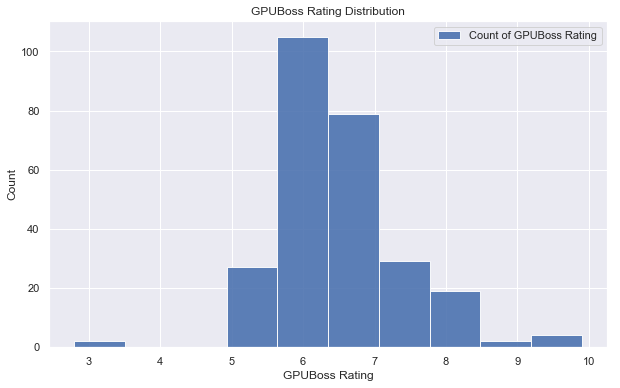

In [3143]:
# histogram of video card ratings from gpuboss - only 11 video cards have a rating > 8.0
sns.set()
plt.figure(figsize=(10,6))
plt.hist(df_updated_2['gpuboss_score'].dropna(), alpha=0.9,label='Count of GPUBoss Rating')
plt.title('GPUBoss Rating Distribution')
plt.xlabel('GPUBoss Rating')
plt.ylabel('Count')
plt.legend();

# Save options
save = 'review_hist'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')

In [2379]:
# move column 'gpuboss_score' to the front of the DataFrame; new DataFrame: df_updated_3
df_updated_3 = df_updated_2[['gpuboss_score'] + [c for c in df_updated_2 if c not in ['gpuboss_score']]]

In [2513]:
df_updated_3.head(3) # head of data

,gpuboss_score,release_date,manufacturer,chipset,dual_gpu,passmark_score,t_rex_gfx_score,manhattan_gfx_score,market,clock_speed_MHz,...,no_dual_gpu,yes_dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
0,NaN,2008-01-01,ATi,Radeon X1050,No,49.0,NaN,NaN,Desktop,400,...,1,0,1,0,0,0,0,0,0,1
1,NaN,2008-01-01,ATi,Mobility Radeon HD 3650,No,216.0,1704.69,NaN,Laptop,500,...,1,0,0,1,0,0,0,1,0,0
2,NaN,2008-01-01,Nvidia,GeForce 8800 GS,No,551.0,NaN,NaN,Desktop,550,...,1,0,1,0,0,0,0,1,0,0


In [1047]:
# group by chipset/gpu name - IS THIS NECESSARY?
df_updated.groupby(['Chipset','GPU_Name']).agg({'Float_Price':'mean'}).sort_values('Float_Price', ascending=False).head(5)

,,Float_Price
Chipset,GPU_Name,
Quadro GP100,PNY VCQGP100-PB,8899.00
Quadro M6000,PNY VCQM6000-PB,4999.00
Quadro P6000,PNY VCQP6000-PB,4576.59
Titan V,NVIDIA 900-1G500-2500-000,3249.00
FirePro W9100,AMD 100-505989,2999.00


### develop a DataFrame with only rows that have gpuboss rating

In [2422]:
df_train = df_updated_3.loc[df_updated_3['gpuboss_score'].notnull()]

In [2425]:
df_train.head(3)

,gpuboss_score,release_date,manufacturer,chipset,dual_gpu,passmark_score,t_rex_gfx_score,manhattan_gfx_score,market,clock_speed_MHz,...,no_dual_gpu,yes_dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
12,6.2,2008-02-01,Nvidia,GeForce GT 9600,No,739.0,NaN,NaN,Desktop,650,...,1,0,1,0,0,0,1,0,0,0
29,6.4,2008-06-01,ATi,Radeon HD 4850,No,1028.0,3357.10,NaN,Desktop,625,...,1,0,1,0,0,0,0,1,0,0
31,6.2,2008-07-01,Nvidia,GeForce GT 9800,No,716.0,3307.06,NaN,Desktop,600,...,1,0,1,0,0,0,0,1,0,0


### Columns to drop (in order to fit data into linear regression / statsmodel):
- manufacturer
- chipset
- dual_gpu
- market
- memory_type

### Columns to drop (no correlation with gpuboss score):
- BIOSTAR
- HIS

In [2458]:
# drop categorical features that have already been transformed to dummy variables
df_train = df_train.drop(['manufacturer','chipset','dual_gpu','market','memory_type'], axis = 1)

# drop features that are not correlated with gpuboss_score
df_train = df_train.drop(['BIOSTAR','HIS'], axis = 1)

### convert datetime values into numerical values

In [ ]:
df_train['release_date']=df_train['release_date'].map(datetime.toordinal)

### We will use K-Nearest Neighbor (KNN) to handle missing data

In this method, k neighbors are chosen based on some distance measure and their average is used as an imputation estimate. The method requires the selection of the number of nearest neighbors, and a distance metric. KNN can predict both discrete attributes (the most frequent value among the k nearest neighbors) and continuous attributes (the mean among the k nearest neighbors)
The distance metric varies according to the type of data:
1. Continuous Data: The commonly used distance metrics for continuous data are Euclidean, Manhattan and Cosine
2. Categorical Data: Hamming distance is generally used in this case. It takes all the categorical attributes and for each, count one if the value is not the same between two points. The Hamming distance is then equal to the number of attributes for which the value was different.

In [2470]:
from fancyimpute import KNN    

# set df_train as numpy array for KNN
df_train_array = df_train.select_dtypes(include=[np.float,np.int]).as_matrix()

# Use 5 nearest rows which have a feature to fill in each row's missing features
df_train_filled = pd.DataFrame(KNN(k=5).fit_transform(df_train_array),columns=df_train.columns,index=df_train.index)

Imputing row 1/267 with 3 missing, elapsed time: 0.074
Imputing row 101/267 with 1 missing, elapsed time: 0.083
Imputing row 201/267 with 4 missing, elapsed time: 0.089


/Users/auyeus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


#### reset the index

In [2518]:
df_train_filled = df_train_filled.reset_index(drop=True)

In [2519]:
df_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 45 columns):
gpuboss_score                        267 non-null float64
release_date                         267 non-null float64
passmark_score                       267 non-null float64
t_rex_gfx_score                      267 non-null float64
manhattan_gfx_score                  267 non-null float64
clock_speed_MHz                      267 non-null float64
turbo_clock_speed_MHz                267 non-null float64
shading_units                        267 non-null float64
texture_mapping_units                267 non-null float64
render_output_processors             267 non-null float64
pixel_rate_GPixel/s                  267 non-null float64
texture_rate_GTexel/s                267 non-null float64
floating_point_performance_GFLOPS    267 non-null float64
memory_clock_speed                   267 non-null float64
effective_memory_clock_speed_MHz     267 non-null float64
memory_bus_bit           

### save KKN-filled DataFrame via Pickle

In [2520]:
# save updated DataFrame with Pickle - dump into new file
with open('df_train_filled.pkl','wb') as picklefile:
    pickle.dump(df_train_filled,picklefile)

In [2521]:
# load pickle file
with open('df_train_filled.pkl','rb') as picklefile:
    df_train_filled = pickle.load(picklefile)

# Statistical Modelling with statsmodel.formula.api + sklearn

In [ ]:
# for statsmodel
import statsmodels.formula.api as smf

# for scikitlearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

# for plotting regression models
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### initial statsmodel summary

In [2665]:
# define the features matrix (X_train) + response variable (y_train)
X = df_train_filled.iloc[:,1:]
y = df_train_filled.iloc[:,0]

# Define the model
lm1 = smf.ols('y ~ X',data=df_train_filled)

# Fit the model
fit1 = lm1.fit()

# Check out the results
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     10.37
Date:                Wed, 10 Oct 2018   Prob (F-statistic):           8.24e-33
Time:                        14:23:07   Log-Likelihood:                -203.65
No. Observations:                 267   AIC:                             489.3
Df Residuals:                     226   BIC:                             636.4
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.5198     30.878      0.956      0.340     -31.325      90.365
X[0]       -7.957e-05   8.83e-05     -0.901      0.369      -0.000    9.45e-05
X[1]        8.258e-05    6.5e-05      1.271      0.205   -4.55e-05       0.000
X[2]        4.418e-06   1.01e-05      0.435      0.664   -1.56e-05    2.44e-05
X[3]        4.717e-05    2.7e-05      1.749      0.082   -5.97e-06       0.000
X[4]           0.0002      0.000      0.363      0.717      -0.001       0.001
X[5]           0.0022      0.000      4.488      0.000       0.001       0.003
X[6]           0.0007      0.000      1.789      0.075   -7.32e-05       0.002
X[7]          -0.0056      0.007     -0.800      0.424      -0.019       0.008
X[8]           0.0238      0.011      2.161      0.032       0.002       0.046
X[9]          -0.0182      0.010     -1.772      0.078      -0.038       0.002
X[10]      -1.502e-05      0.008     -0.002      0.999      -0.016       0.016
X[11]          0.0001      0.000      0.402      0.688      -0.000       0.001
X[12]          0.0001      0.000      0.492      0.623      -0.000       0.001
X[13]         -0.0001   9.36e-05     -1.350      0.178      -0.000     5.8e-05
X[14]         -0.0004      0.000     -2.981      0.003      -0.001      -0.000
X[15]      -3.626e-05   3.69e-05     -0.982      0.327      -0.000    3.65e-05
X[16]          0.0030      0.001      2.047      0.042       0.000       0.006
X[17]         -0.0063      0.002     -3.966      0.000      -0.010      -0.003
X[18]          1.8999      1.973      0.963      0.337      -1.988       5.788
X[19]          1.6532      2.001      0.826      0.409      -2.289       5.595
X[20]          1.4634      1.907      0.768      0.444      -2.293       5.220
X[21]          1.7591      1.989      0.885      0.377      -2.159       5.678
X[22]          1.9219      2.008      0.957      0.340      -2.035       5.879
X[23]          2.1640      1.968      1.100      0.273      -1.714       6.042
X[24]          1.8142      2.024      0.897      0.371      -2.173       5.802
X[25]          1.7085      1.954      0.874      0.383      -2.143       5.560
X[26]          2.1958      1.993      1.102      0.272      -1.731       6.123
X[27]          1.2454      1.944      0.641      0.522      -2.585       5.076
X[28]          2.1544      1.945      1.108      0.269      -1.678       5.987
X[29]          1.2412      1.959      0.634      0.527      -2.618       5.101
X[30]          1.8891      2.021      0.935      0.351      -2.092       5.871
X[31]          1.9454      1.957      0.994      0.321      -1.911       5.802
X[32]          1.9041      1.987      0.958      0.339      -2.011       5.819
X[33]          2.5602      2.003      1.278      0.203      -1.387       6.508
X[34]         15.1387     15.421      0.982      0.327     -15.249      45.527
X[

### Residual Plot - for checking out error randomness (the more random, the better)

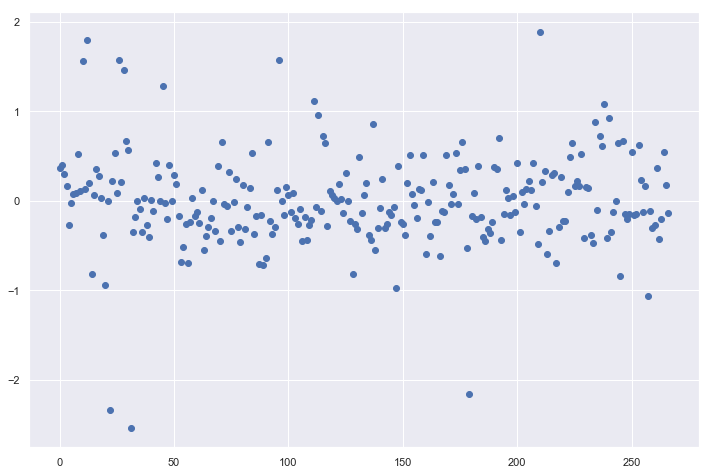

In [2669]:
# Use statsmodels to plot the residuals
fit1.resid.plot(style='o', figsize=(12,8));

In [2491]:
df_train_filled.corr()

,gpuboss_score,release_date,passmark_score,t_rex_gfx_score,manhattan_gfx_score,clock_speed_MHz,turbo_clock_speed_MHz,shading_units,texture_mapping_units,render_output_processors,...,no_dual_gpu,yes_dual_gpu,desktop_market,laptop_market,undefined_market,DDR2_memory,DDR3_memory,GDDR3_memory,GDDR5_memory,undefined_memory
gpuboss_score,1.000000,0.409805,0.688057,0.364252,0.451478,0.555636,0.627362,0.553429,0.532667,0.589841,...,-0.103994,0.103994,0.112329,-0.106926,-0.011081,-0.134267,-0.227493,-0.165233,0.338552,-0.000053
release_date,0.409805,1.000000,0.523384,0.164474,0.215092,0.679075,0.597825,0.399467,0.331146,0.315130,...,-0.022692,0.022692,-0.172413,-0.020663,0.336918,-0.186538,0.028221,-0.368745,0.257487,-0.034691
passmark_score,0.688057,0.523384,1.000000,0.378478,0.443947,0.655017,0.698316,0.816230,0.800365,0.846022,...,-0.205384,0.205384,0.258232,-0.348973,0.153123,-0.122659,-0.415004,-0.243228,0.534218,0.041208
t_rex_gfx_score,0.364252,0.164474,0.378478,1.000000,0.616925,0.214841,0.255966,0.248384,0.241853,0.378054,...,0.002412,-0.002412,0.123978,-0.115769,-0.016118,-0.074517,-0.138857,-0.075630,0.195599,-0.016254
manhattan_gfx_score,0.451478,0.215092,0.443947,0.616925,1.000000,0.350055,0.421582,0.347346,0.357170,0.425216,...,-0.065759,0.065759,0.121363,-0.132352,0.017158,-0.157099,-0.266972,-0.141194,0.368622,-0.007390
clock_speed_MHz,0.555636,0.679075,0.655017,0.214841,0.350055,1.000000,0.863153,0.446891,0.381445,0.444751,...,-0.030728,0.030728,0.178539,-0.288367,0.187394,-0.141957,-0.144217,-0.285437,0.361155,-0.064746
turbo_clock_speed_MHz,0.627362,0.597825,0.698316,0.255966,0.421582,0.863153,1.000000,0.457793,0.401209,0.494616,...,-0.041292,0.041292,0.128682,-0.282301,0.263974,-0.121511,-0.227529,-0.251532,0.381769,0.012055
shading_units,0.553429,0.399467,0.816230,0.248384,0.347346,0.446891,0.457793,1.000000,0.971770,0.872612,...,-0.568477,0.568477,0.235348,-0.273694,0.062766,-0.106219,-0.339060,-0.190235,0.378575,0.182124
texture_mapping_units,0.532667,0.331146,0.800365,0.241853,0.357170,0.381445,0.401209,0.971770,1.000000,0.883071,...,-0.602752,0.602752,0.248741,-0.267476,0.028608,-0.102248,-0.353369,-0.171592,0.387729,0.158987
render_output_processors,0.589841,0.315130,0.846022,0.378054,0.425216,0.444751,0.494616,0.872612,0.883071,1.000000,...,-0.545887,0.545887,0.267573,-0.266068,-0.006723,-0.114788,-0.382504,-0.210300,0.466033,0.088636


## Correlation between response variable + all the features observed initially

Saving graph to: initial_corr_heatmap.svg


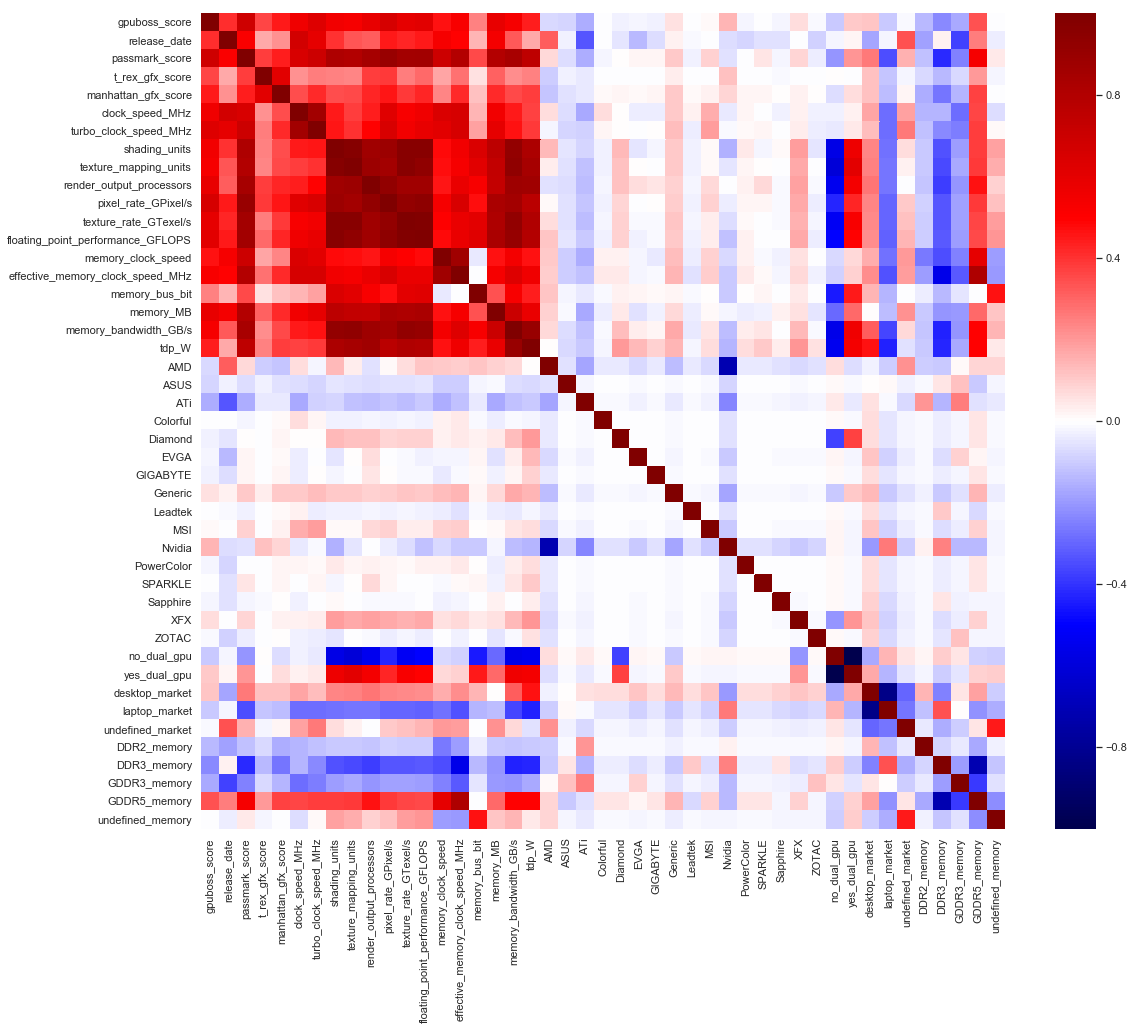

In [3112]:
# example of a better corr matrix
plt.figure(figsize=(18,15))  
sns.heatmap(df_train_filled.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);

# Save options
save = 'initial_corr_heatmap'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')

### Let's try to use scikitlearn

In [2670]:
# Create an empty model
lr1 = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# feature variables
X = df_train_filled.iloc[:,1:]

# Choose the response variable(s)
y = df_train_filled.iloc[:,0]


# Fit the model to the full dataset
lr1.fit(X, y)

# Print out the R^2 for the model against the full dataset
lr1.score(X, y)

0.6473639601287633

## use SKLEARN to predict values (based on LR model)

- there is a .predict() function

#### Maybe a polynomial regression would fit better? Let's find out

- question: how do you define the ground truth of your raw data set?

## Based on range of values in different columns (e.g. highest seems to be datetime turned into int) - is standardization required?

In [2671]:
df_train_filled.iloc[:,0:20].head(5)

,gpuboss_score,release_date,passmark_score,t_rex_gfx_score,manhattan_gfx_score,clock_speed_MHz,turbo_clock_speed_MHz,shading_units,texture_mapping_units,render_output_processors,pixel_rate_GPixel/s,texture_rate_GTexel/s,floating_point_performance_GFLOPS,memory_clock_speed,effective_memory_clock_speed_MHz,memory_bus_bit,memory_MB,memory_bandwidth_GB/s,tdp_W,AMD
0,6.2,733073.0,739.0,3025.847375,2476.275617,650.0,828.219279,64.0,32.0,16.0,10.4,20.8,208.0,900.0,1800.0,256.0,512.0,57.60,95.0,0.0
1,6.4,733194.0,1028.0,3357.100000,2831.877443,625.0,855.228903,800.0,40.0,16.0,10.0,25.0,1000.0,993.0,1986.0,256.0,512.0,63.55,110.0,0.0
2,6.2,733224.0,716.0,3307.060000,2800.568477,600.0,851.229285,112.0,56.0,16.0,9.6,33.6,336.0,900.0,1800.0,256.0,512.0,57.60,125.0,0.0
3,6.3,733224.0,279.0,1031.358866,2097.312262,550.0,778.196012,32.0,16.0,8.0,4.4,8.8,89.6,800.0,1600.0,128.0,512.0,25.60,50.0,0.0
4,5.7,733316.0,964.0,3354.320000,2845.253225,575.0,852.343092,640.0,32.0,16.0,9.2,18.4,736.0,900.0,1800.0,256.0,512.0,57.60,95.0,0.0


## Train, Validate, and Test Model (via cross-validation)

In [2548]:
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split # randomly creates test sets
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score

### using cross-validation to capture MSE

In [2673]:
# 5-fold cross-validation with data
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=5, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

[0.76641546 0.26978743 0.26078552 0.36968391 5.19729463]


### using cross-validation to capture R^2 results

In [2675]:
# 5-fold cross-validation with current data set
reg = LinearRegression()
r2_avg = cross_val_score(reg, X, y, cv=5, scoring='r2').mean()

# check r2 average
print(r2_avg)

-0.5682452442314035


### Let's use feature_selection from sklearn to narrow our features

In [2676]:
from sklearn import feature_selection as f_select

est = LinearRegression()
sig_columns = [] # used to capture columns from X_train that have low p-values
pvals = []

# iterate and find features with p-values < .02
for feature in X_train.columns:
    pval = f_select.f_regression(X[[feature]],y)
    #print(pval)
    if pval[1][0] < .02:
        sig_columns.append(feature)
        pvals.append(pval[1][0])

# save features with low p-values to new variable
X_transformed = X[sig_columns]

# with reduced features, cross-validate again
cross_val_score(est,X_transformed,y,cv=10,scoring='r2').mean()

-0.29858517700304954

### Regularization - LASSO

0.5599705990889852

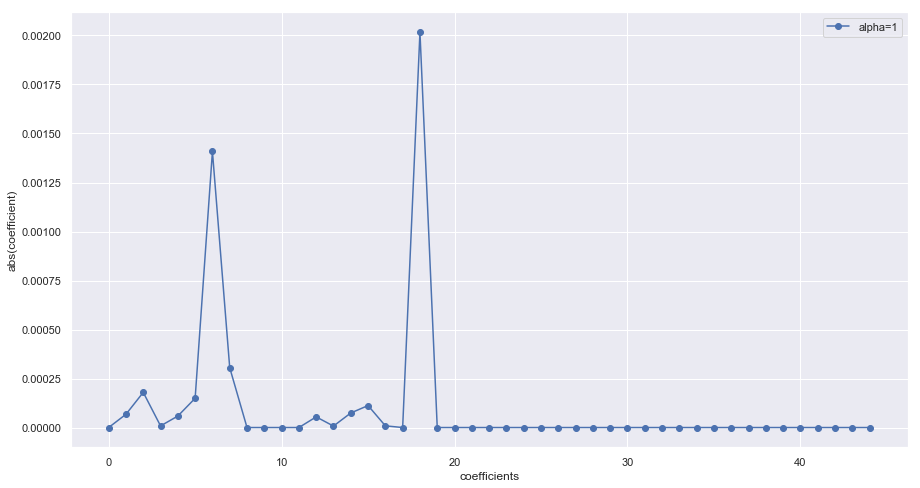

In [2679]:
from sklearn.linear_model import Lasso

degree = 1
alpha = 1

est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
est.fit(X, y)

# get coefs after fitting into Lasso Regression
coef = est.steps[-1][1].coef_.ravel()

plt.figure(figsize=(15,8))
plt.plot(np.abs(coef), marker='o', label='alpha=%r' % alpha)
plt.ylabel('abs(coefficient)')
plt.xlabel('coefficients')
plt.legend()
#plt.set_xlim((1, 9))
#plt.ylim(-1000,1e6)

#plot_coefficients(est, ax_right, label='Lasso(alpha=%r) coefficients' % alpha, yscale=None)
#ax_right.set_ylim((1e-1, 15))
est.score(X,y)

In [2697]:
est.intercept_ # intercept does exist

99.2785358068713

## Try to find the best alpha for Lasso Regression

In [2693]:
# A bit more involved approach: illustrated here with Lasso
kf = KFold(n=len(X), n_folds=5, shuffle=True) # shuffles the data

all_scores=[]
alphas=[1e-5,1e-3,1e-1,0,1,10]


for train, test in kf:
    X_train=X.iloc[train]
    y_train=y.iloc[train]
    x_test=X.iloc[test]
    y_test=y.iloc[test]
    mse_score=[]
    for a in alphas:
        est=Lasso(alpha=a)
        est.fit(X_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
    all_scores.append(mse_score)

No handles with labels found to put in legend.


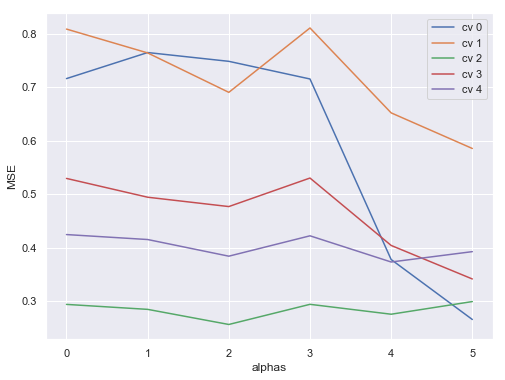

In [2694]:
# Which alpha is the best for our model ? Looks like 1...
plt.figure(figsize=(8,6))
#plt.ylim(0,0.1)
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.show()

In [2695]:
set_alpha = 1

# Take a quick look at our strongest features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

est=Lasso(alpha=set_alpha)
est.fit(X_train,y_train)


zipped=zip(X_train.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features[:]


[('turbo_clock_speed_MHz', 0.0013089773939936604),
 ('shading_units', 0.00035976666573942135),
 ('clock_speed_MHz', 0.00020122939142140688),
 ('passmark_score', 0.00017813865757934915),
 ('manhattan_gfx_score', 6.610595802569672e-05),
 ('floating_point_performance_GFLOPS', 4.019282456981478e-05),
 ('t_rex_gfx_score', 1.1180497380951907e-05),
 ('texture_mapping_units', 0.0),
 ('render_output_processors', 0.0),
 ('pixel_rate_GPixel/s', 0.0),
 ('texture_rate_GTexel/s', 0.0),
 ('memory_bus_bit', -0.0),
 ('memory_bandwidth_GB/s', -0.0),
 ('AMD', -0.0),
 ('ASUS', -0.0),
 ('ATi', 0.0),
 ('Colorful', 0.0),
 ('Diamond', -0.0),
 ('EVGA', 0.0),
 ('GIGABYTE', 0.0),
 ('Generic', -0.0),
 ('Leadtek', 0.0),
 ('MSI', -0.0),
 ('Nvidia', 0.0),
 ('PowerColor', 0.0),
 ('SPARKLE', -0.0),
 ('Sapphire', -0.0),
 ('XFX', 0.0),
 ('ZOTAC', 0.0),
 ('no_dual_gpu', 0.0),
 ('yes_dual_gpu', -0.0),
 ('desktop_market', -0.0),
 ('laptop_market', 0.0),
 ('undefined_market', -0.0),
 ('DDR2_memory', 0.0),
 ('DDR3_memory', 0

### Given Lasso results, lets remove some features!

In [2699]:
# copy regular matrix X to new variable
X_reduced = X 

# remove features from matrix X_reduced, where Lasso reduced coefficient to zero
X_reduced = X_reduced.drop(columns=['texture_mapping_units','render_output_processors','pixel_rate_GPixel/s',
                                    'texture_rate_GTexel/s','memory_bus_bit','memory_bandwidth_GB/s','AMD','ASUS',
                                    'ATi','Colorful','Diamond','EVGA','GIGABYTE','Generic','Leadtek','MSI','Nvidia',
                                    'PowerColor','SPARKLE','Sapphire','XFX','ZOTAC','no_dual_gpu','yes_dual_gpu',
                                    'desktop_market','laptop_market','undefined_market','DDR2_memory','DDR3_memory',
                                    'GDDR3_memory','GDDR5_memory','undefined_memory'])

In [2704]:
len(X_reduced.columns) # 12 features in new matrix

12

In [2705]:
X_reduced.columns

Index(['release_date', 'passmark_score', 't_rex_gfx_score',
       'manhattan_gfx_score', 'clock_speed_MHz', 'turbo_clock_speed_MHz',
       'shading_units', 'floating_point_performance_GFLOPS',
       'memory_clock_speed', 'effective_memory_clock_speed_MHz', 'memory_MB',
       'tdp_W'],
      dtype='object')

## With reduced set of features, lets see how that affects the LR model

In [2706]:
# statsmodel

# Define the model
lm2 = smf.ols('y ~ X_reduced',data=df_train_filled)

# Fit the model
fit2 = lm2.fit()

# Check out the results
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     26.82
Date:                Wed, 10 Oct 2018   Prob (F-statistic):           1.25e-38
Time:                        15:32:18   Log-Likelihood:                -233.53
No. Observations:                 267   AIC:                             493.1
Df Residuals:                     254   BIC:                             539.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        84.1517     52.349      1.608      0.109     -18.942     187.245
X_reduced[0]     -0.0001   7.14e-05     -1.517      0.130      -0.000    3.23e-05
X_reduced[1]      0.0002   4.32e-05      4.334      0.000       0.000       0.000
X_reduced[2]   8.372e-06   9.91e-06      0.845      0.399   -1.11e-05    2.79e-05
X_reduced[3]   6.247e-05   2.45e-05      2.549      0.011    1.42e-05       0.000
X_reduced[4]      0.0003      0.000      0.660      0.510      -0.001       0.001
X_reduced[5]      0.0014      0.000      3.040      0.003       0.000       0.002
X_reduced[6]      0.0004      0.000      1.897      0.059   -1.35e-05       0.001
X_reduced[7]     -0.0001      0.000     -1.040      0.299      -0.000    9.37e-05
X_reduced[8]   6.234e-05      0.000      0.255      0.799      -0.000       0.001
X_reduced[9]  -6.854e-05   4.65e-05     -1.474      0.142      -0.000     2.3e-05
X_reduced[10]  4.288e-06   3.23e-05      0.133      0.894   -5.93e-05    6.78e-05
X_reduced[11]    -0.0026      0.001     -2.876      0.004      -0.004      -0.001
==============================================================================
Omnibus:                       50.337   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.657
Skew:                          -0.470   Prob(JB):                     8.85e-81
Kurtosis:                       8.679   Cond. No.                     1.06e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

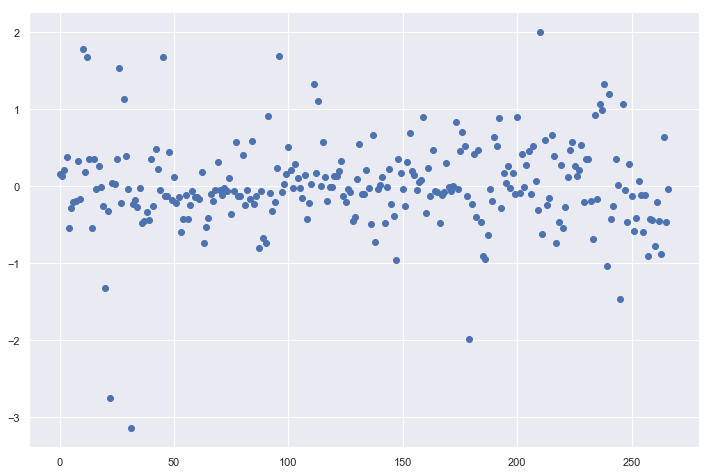

In [2707]:
# Use statsmodels to plot the residuals
fit2.resid.plot(style='o', figsize=(12,8));

## Cross-Validation: mean_squared_error

In [2710]:
# 5-fold cross-validation with data
reg = LinearRegression()
scores = cross_val_score(reg, X_reduced, y, cv=5, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

[0.67726401 0.18023297 0.18575786 0.35163308 0.96910183]


## Cross-Validation: R^2 average

In [2709]:
# 5-fold cross-validation with current data set
reg = LinearRegression()
r2_avg = cross_val_score(reg, X_reduced, y, cv=5, scoring='r2').mean()

# check r2 average
print(r2_avg)

0.2786600867324127


## Let's try to remove more features via Lasso

In [3184]:
# set KFold (5 folds)
kf = KFold(n=len(X_reduced), n_folds=5, shuffle=True) # shuffles the data

all_scores=[]
alphas=[1e-2,1e-1,0,1,10,100]

# capture all the MSEs
for train, test in kf:
    X_train=X_reduced.iloc[train]
    y_train=y.iloc[train]
    x_test=X_reduced.iloc[test]
    y_test=y.iloc[test]
    mse_score=[]
    for a in alphas:
        est=Lasso(alpha=a)
        est.fit(X_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
    all_scores.append(mse_score)

No handles with labels found to put in legend.


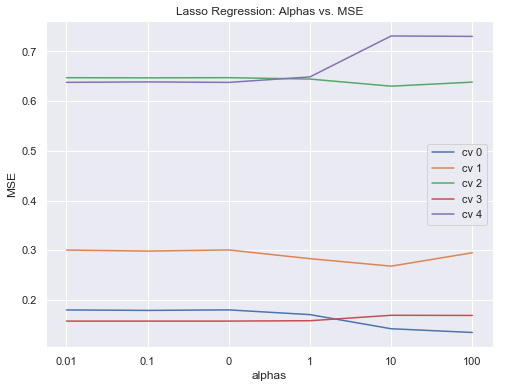

In [3185]:
# Which alpha is the best for our model ? Looks like 1 or 10
plt.figure(figsize=(8,6))
#plt.ylim(0,0.1)
plt.legend()
for i in range(5):
    plt.plot(all_scores[i],label = 'cv %s'%i)
plt.legend()
plt.title('Lasso Regression: Alphas vs. MSE')
plt.xlabel('alphas')
plt.ylabel('MSE')
plt.xticks(range(6),alphas)
plt.show()

## let's try to get a more specific alpha for regularization

In [2777]:
# define KFold
kf = KFold(n=len(X_reduced), n_folds=5, shuffle=True) # shuffles the data

all_scores=[]
alphas2 = np.linspace(1, 10, num=100) # check alphas between 1 and 10
lowest_alpha = 0
mse_lowest = 1

for train, test in kf:
    X_train=X_reduced.iloc[train]
    y_train=y.iloc[train]
    x_test=X_reduced.iloc[test]
    y_test=y.iloc[test]
    mse_score=[]
    for a in alphas2:
        est=Lasso(alpha=a)
        est.fit(X_train,y_train)
        mse=np.mean((y_test-est.predict(x_test))**2)
        mse_score.append(mse)
    if mse_lowest > np.mean(mse_score):
        mse_lowest = np.mean(mse_score)
        lowest_alpha = a

print('lowest MSE average score: ' + str(mse_lowest))
print('optimal alpha: ' + str(lowest_alpha)) 
# apparently the higher the alpha, the better it is for the Lasso Regression...

lowest MSE average score: 0.2412654948860677
optimal alpha: 10.0


In [2839]:
set_alpha = 10 # supposedly the optimal alpha for Lasso

# Take a quick look at our strongest features
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3)

est=Lasso(alpha=set_alpha)
est.fit(X_train,y_train)


zipped=zip(X_train.columns,est.coef_)
features=sorted(zipped,key = lambda t: t[1],reverse=True)
features[:]

[('turbo_clock_speed_MHz', 0.0005521351393292334),
 ('passmark_score', 0.0001631564215547337),
 ('manhattan_gfx_score', 5.0718376046849385e-05),
 ('memory_MB', 2.824441900813298e-05),
 ('t_rex_gfx_score', 7.267548060537794e-06),
 ('release_date', -0.0),
 ('clock_speed_MHz', 0.0),
 ('shading_units', 0.0),
 ('floating_point_performance_GFLOPS', 0.0),
 ('memory_clock_speed', 0.0),
 ('tdp_W', -0.0),
 ('effective_memory_clock_speed_MHz', -1.2776608651786177e-05)]

## Per Lasso results, lets drop some more features

In [2891]:
# copy X_reduced to new variable
X_reduced_2 = X_reduced

# remove features from matrix X_reduced_2, where Lasso reduced coefficient to zero
X_reduced_2 = X_reduced_2.drop(columns=['release_date','clock_speed_MHz','shading_units','memory_clock_speed',
                                        'floating_point_performance_GFLOPS'])

In [2892]:
X_reduced_2.columns # down to 7 features

Index(['passmark_score', 't_rex_gfx_score', 'manhattan_gfx_score',
       'turbo_clock_speed_MHz', 'effective_memory_clock_speed_MHz',
       'memory_MB', 'tdp_W'],
      dtype='object')

## Once again, let's see how the narrower scope of features perform

In [2893]:
# statsmodel

# Define the model
lm3 = smf.ols('y ~ X_reduced_2',data=df_train_filled)

# Fit the model
fit3 = lm3.fit()

# Check out the results
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     44.70
Date:                Wed, 10 Oct 2018   Prob (F-statistic):           3.78e-41
Time:                        18:26:17   Log-Likelihood:                -237.05
No. Observations:                 267   AIC:                             490.1
Df Residuals:                     259   BIC:                             518.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.9333      0.258     19.132      0.000       4.426       5.441
X_reduced_2[0]     0.0002   3.92e-05      5.000      0.000       0.000       0.000
X_reduced_2[1]  7.428e-06   9.88e-06      0.752      0.453    -1.2e-05    2.69e-05
X_reduced_2[2]  5.521e-05   2.35e-05      2.352      0.019    8.99e-06       0.000
X_reduced_2[3]     0.0012      0.000      3.876      0.000       0.001       0.002
X_reduced_2[4] -5.928e-05    3.2e-05     -1.850      0.065      -0.000    3.81e-06
X_reduced_2[5]  7.903e-06   2.76e-05      0.286      0.775   -4.64e-05    6.22e-05
X_reduced_2[6]    -0.0012      0.001     -1.733      0.084      -0.003       0.000
==============================================================================
Omnibus:                       43.905   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.956
Skew:                          -0.353   Prob(JB):                     1.34e-67
Kurtosis:                       8.214   Cond. No.                     6.17e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.17e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## what if we removed two more feature? based on statsmodel?

In [2894]:
# remove features from matrix X_reduced_2, where p-value is greater than 0.10 in statsmodel
X_reduced_2 = X_reduced_2.drop(columns=['t_rex_gfx_score','memory_MB'])

In [2895]:
X_reduced_2.columns

Index(['passmark_score', 'manhattan_gfx_score', 'turbo_clock_speed_MHz',
       'effective_memory_clock_speed_MHz', 'tdp_W'],
      dtype='object')

In [2896]:
# let's remove the feature with the highest p-value: floating_point_performance_GFLOPS

# Define the model
lm4 = smf.ols('y ~ X_reduced_2',data=df_train_filled)

# Fit the model
fit4 = lm4.fit()

# Check out the results
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     62.79
Date:                Wed, 10 Oct 2018   Prob (F-statistic):           8.09e-43
Time:                        18:26:23   Log-Likelihood:                -237.37
No. Observations:                 267   AIC:                             486.7
Df Residuals:                     261   BIC:                             508.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.9620      0.254     19.518      0.000       4.461       5.463
X_reduced_2[0]     0.0002   3.09e-05      6.756      0.000       0.000       0.000
X_reduced_2[1]  6.596e-05   1.89e-05      3.483      0.001    2.87e-05       0.000
X_reduced_2[2]     0.0012      0.000      3.887      0.000       0.001       0.002
X_reduced_2[3] -6.446e-05   3.03e-05     -2.130      0.034      -0.000   -4.88e-06
X_reduced_2[4]    -0.0013      0.001     -1.903      0.058      -0.003     4.5e-05
==============================================================================
Omnibus:                       44.165   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.675
Skew:                          -0.362   Prob(JB):                     1.55e-67
Kurtosis:                       8.209   Cond. No.                     4.53e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

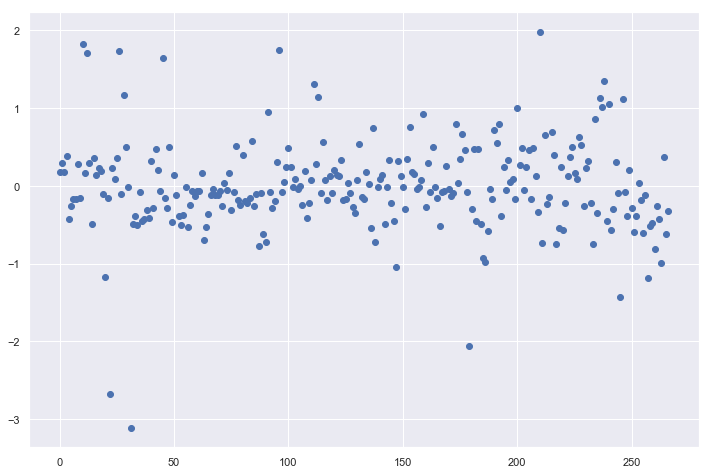

In [2897]:
# Use statsmodels to plot the residuals
fit4.resid.plot(style='o', figsize=(12,8));

In [2898]:
# 5-fold cross-validation with data
reg = LinearRegression()
scores = cross_val_score(reg, X_reduced_2, y, cv=5, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

[0.6766801  0.1740013  0.19398165 0.35749515 0.4935979 ]


In [2899]:
# 5-fold cross-validation with current data set
reg = LinearRegression()
r2_avg = cross_val_score(reg, X_reduced_2, y, cv=5, scoring='r2').mean()

# check r2 average
print(r2_avg)

0.3562532513393812


## Plot each feature against the response variable (y) - see if transformation is needed

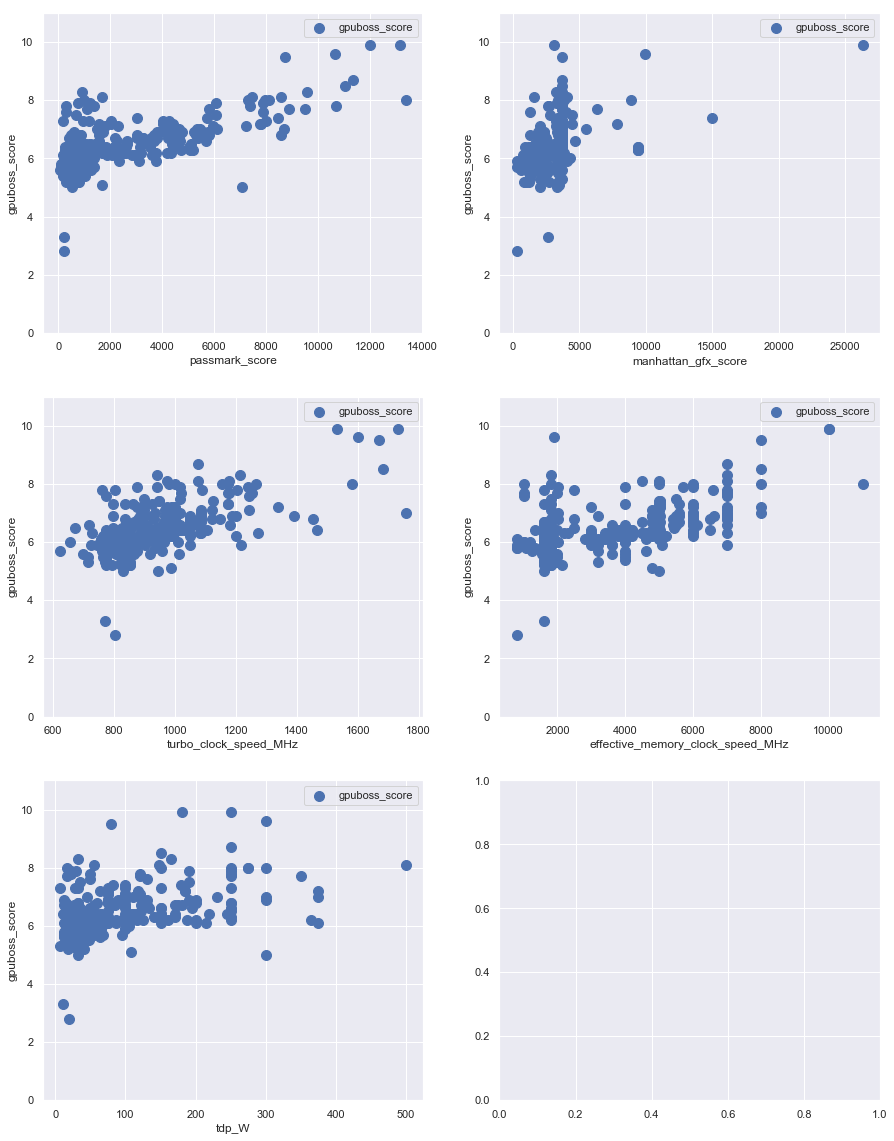

In [2900]:
# Set up a figure and axes for 5 plots, 2 per row for 3 rows
fig, ax_rows = plt.subplots(3, 2, figsize=(15, 20))

# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(feature, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    #ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X_reduced_2.iloc[:,feature], y, s=100)
    #ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((0, 11))
    #ax.set_xlim((0, 1))
    ax.set_ylabel('gpuboss_score')
    ax.set_xlabel(X_reduced_2.columns[feature])
    ax.legend(loc='upper right',frameon=True)

for feature in range(5):
    #est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    #est.fit(X, y)
    # This sets the appropriate axis for each degree (KEEP)
    ax_row_left, ax_row_right = ax_rows[feature//2]
    if feature%2 == 0:
        ax = ax_row_left
    else:
        ax = ax_row_right
    plot_approximation(feature, ax, label='feature=%s' % X_reduced_2.columns[feature])

## quickly save latest dataframe via pickle

In [2879]:
# save updated DataFrame with Pickle - dump into new file
with open('df_final.pkl','wb') as picklefile:
    pickle.dump(df_final,picklefile)

In [3100]:
# load pickle file
with open('df_final.pkl','rb') as picklefile:
    df_final = pickle.load(picklefile)

In [3101]:
df_final.head(3)

,gpuboss_score,passmark_score,manhattan_gfx_score,turbo_clock_speed_MHz,effective_memory_clock_speed_MHz,tdp_W
0,6.2,739.0,2476.275617,828.219279,1800.0,95.0
1,6.4,1028.0,2831.877443,855.228903,1986.0,110.0
2,6.2,716.0,2800.568477,851.229285,1800.0,125.0


## Trying Log Transformation here:

In [3102]:
# log transform features 

# passmark_score
df_final.iloc[:,1] = df_final.iloc[:,1].apply(np.log)

# manhattan_gfx_score
df_final.iloc[:,2] = df_final.iloc[:,2].apply(np.log)

# turbo_clock_speed_MHz
df_final.iloc[:,3] = df_final.iloc[:,3].apply(np.log)

# effective_memory_clock_speed_MHz
df_final.iloc[:,4] = df_final.iloc[:,4].apply(np.log)

# turbo_clock_speed_MHz
df_final.iloc[:,5] = df_final.iloc[:,5].apply(np.log)

df_final.head(3)

,gpuboss_score,passmark_score,manhattan_gfx_score,turbo_clock_speed_MHz,effective_memory_clock_speed_MHz,tdp_W
0,6.2,6.605298,7.814511,6.719278,7.495542,4.553877
1,6.4,6.935370,7.948695,6.751369,7.593878,4.700480
2,6.2,6.573680,7.937578,6.746682,7.495542,4.828314


In [3103]:
# set log-features matrix + response variable
X_reduced_3 = df_final.iloc[:,1:]
y = df_final.iloc[:,0]

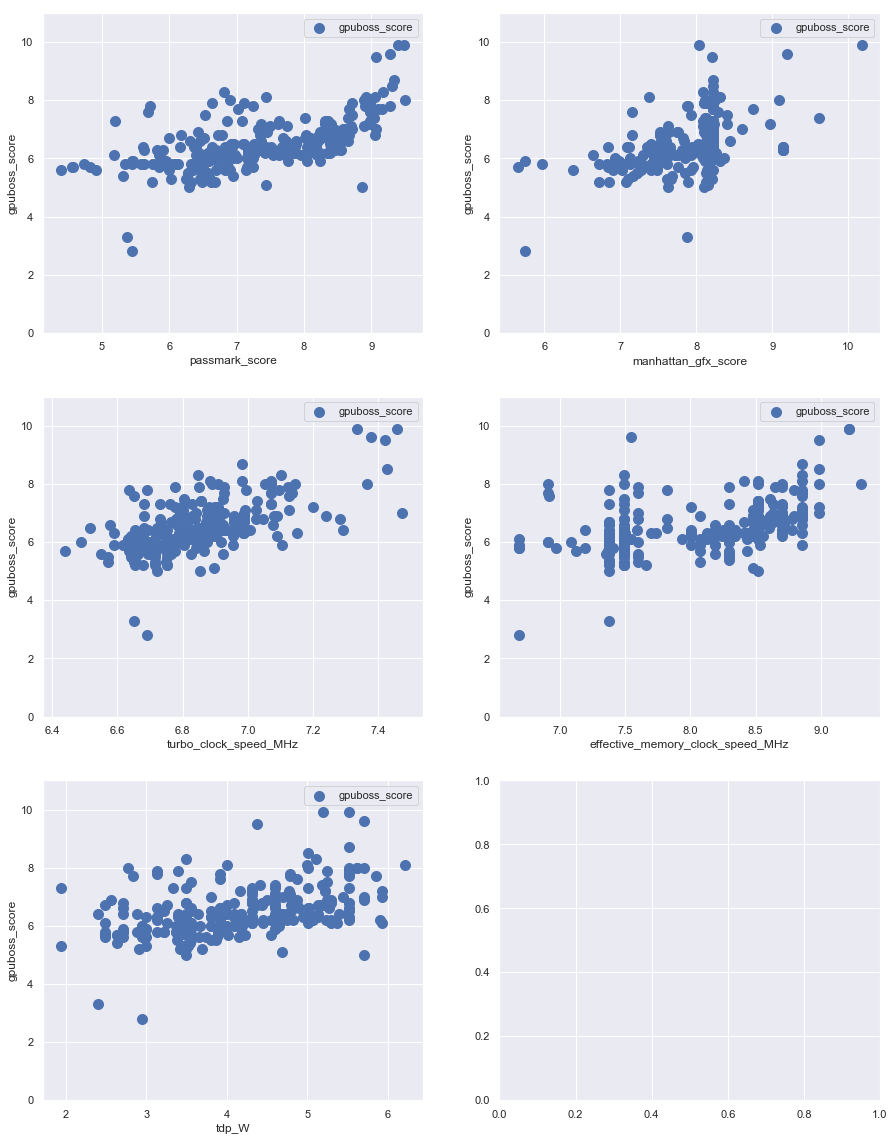

In [3104]:
# Set up a figure and axes for 5 plots, 2 per row for 3 rows
fig, ax_rows = plt.subplots(3, 2, figsize=(15, 20))

# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(feature, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    #ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X_reduced_3.iloc[:,feature], y, s=100)
    #ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((0, 11))
    #ax.set_xlim((0, 1))
    ax.set_ylabel('gpuboss_score')
    ax.set_xlabel(X_reduced_3.columns[feature])
    ax.legend(loc='upper right',frameon=True)

for feature in range(5):
    #est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    #est.fit(X, y)
    # This sets the appropriate axis for each degree (KEEP)
    ax_row_left, ax_row_right = ax_rows[feature//2]
    if feature%2 == 0:
        ax = ax_row_left
    else:
        ax = ax_row_right
    plot_approximation(feature, ax, label='feature=%s' % X_reduced_3.columns[feature])

## log features seem like a better fit - let's check with statsmodel

In [3105]:
# Define the model
lm5 = smf.ols('y ~ X_reduced_3',data=df_final)

# Fit the model
fit5 = lm5.fit()

# Check out the results
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     50.35
Date:                Thu, 11 Oct 2018   Prob (F-statistic):           2.12e-36
Time:                        07:39:14   Log-Likelihood:                -252.65
No. Observations:                 267   AIC:                             517.3
Df Residuals:                     261   BIC:                             538.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -7.8704      1.930     -4.079      0.000     -11.670      -4.071
X_reduced_3[0]     0.4737      0.098      4.849      0.000       0.281       0.666
X_reduced_3[1]     0.2637      0.089      2.958      0.003       0.088       0.439
X_reduced_3[2]     1.7263      0.309      5.587      0.000       1.118       2.335
X_reduced_3[3]    -0.2651      0.113     -2.336      0.020      -0.489      -0.042
X_reduced_3[4]    -0.2098      0.084     -2.500      0.013      -0.375      -0.045
==============================================================================
Omnibus:                       20.156   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.744
Skew:                           0.117   Prob(JB):                     3.21e-15
Kurtosis:                       5.438   Cond. No.                         795.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Saving graph to: final_residual.svg


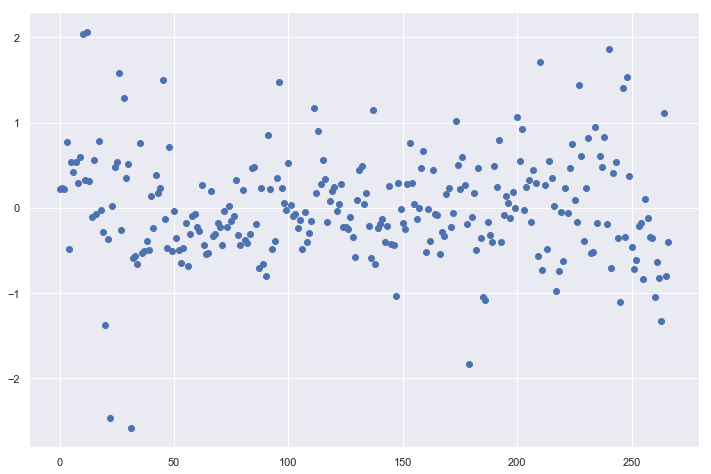

In [3149]:
# Use statsmodels to plot the residuals
fit5.resid.plot(style='o', figsize=(12,8));

# Save options
save = 'final_residual'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')

## check with cross-validation

In [3106]:
# 5-fold cross-validation with data
reg = LinearRegression()
scores = cross_val_score(reg, X_reduced_3, y, cv=5, scoring='mean_squared_error')

# scores output is negative, a sklearn quirk bc mse is used to min. optimization func.
print(-scores)

[0.83651541 0.20036996 0.21485992 0.33615325 0.69955771]


In [3107]:
# 5-fold cross-validation with current data set
reg = LinearRegression()
r2_avg = cross_val_score(reg, X_reduced_3, y, cv=5, scoring='r2').mean()

# check r2 average
print(r2_avg)

0.24995072218549003


## check regression is linear in parameters & correctly specified

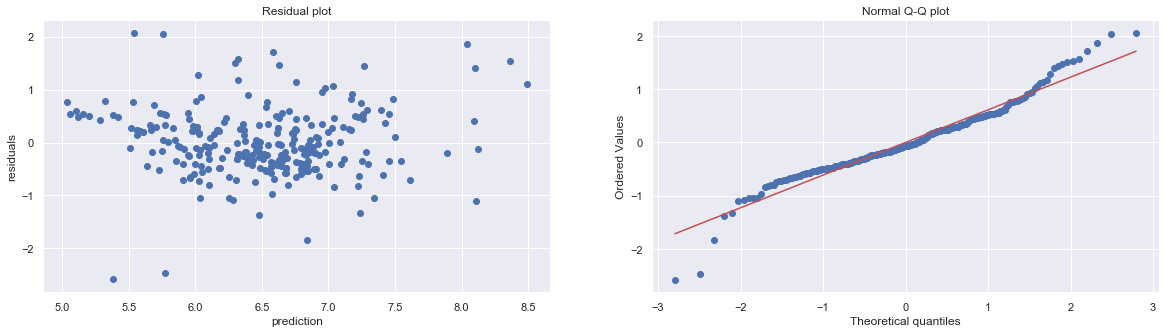

In [3108]:
import scipy.stats as stats # for Q-Q plot + box-cox

plt.figure(figsize=(20,5))

rgr = LinearRegression()
rgr.fit(X_reduced_3,y)
pred = rgr.predict(X_reduced_3)

# regression plot
res = y - pred
plt.subplot(1,2,1)
plt.scatter(pred,res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

# Q-Q plot; if plot looks crazy, something is wrong
# Generates a probability plot of sample data against the quantiles of a 
#specified theoretical distribution 
plt.subplot(1,2,2)
stats.probplot(res,dist='norm',plot=plt)
plt.title("Normal Q-Q plot");

## check the error term has constant variance (Box-Cox method)

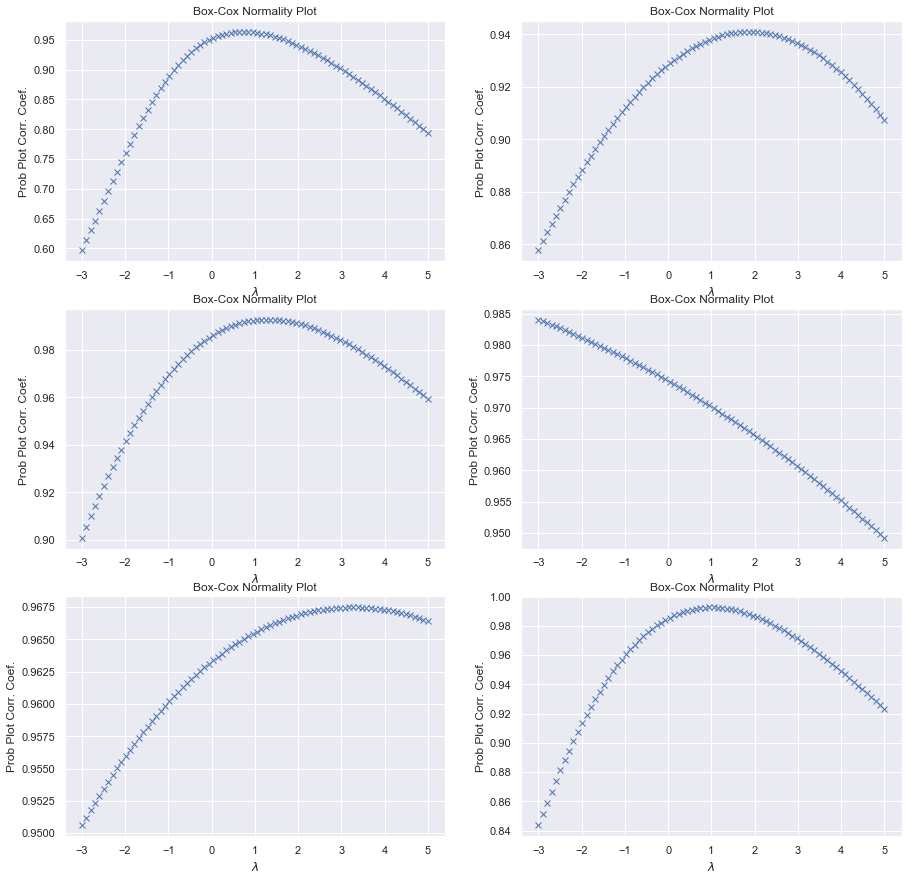

In [3076]:
# box-cox

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(321)
prob = stats.boxcox_normplot(df_final.gpuboss_score,-3,5,plot=ax) # gpuboss_score

ax = fig.add_subplot(322)
prob = stats.boxcox_normplot(df_final.manhattan_gfx_score,-3,5,plot=ax) # manhattan_gfx_score

ax = fig.add_subplot(323)
prob = stats.boxcox_normplot(df_final.passmark_score,-3,5,plot=ax) # passmark_score

ax = fig.add_subplot(324)
prob = stats.boxcox_normplot(df_final.turbo_clock_speed_MHz,-3,5,plot=ax) # turbo_clock_speed_MHz

ax = fig.add_subplot(325)
prob = stats.boxcox_normplot(df_final.effective_memory_clock_speed_MHz,-3,5,plot=ax) # effective_memory_clock_speed

ax = fig.add_subplot(326)
prob = stats.boxcox_normplot(df_final.tdp_W,-3,5,plot=ax) # tdp_W

### Loop to box-cox transform every feature + response variable

In [3092]:
# box-cox transform all features + response variable
for feature in range(6):
    lamb = stats.boxcox_normmax(df_final.iloc[:,feature],brack=(-1.9,1.9))
    df_final.iloc[:,feature] = (np.power(df_final.iloc[:,feature],lamb)-1)/lamb
    

# lamb=stats.boxcox_normmax(df_final.gpuboss_score, brack=(-1.0, 1.5)) # searching over lambda values -1.0 to 1.5
# # find optimal lambda to transform data towards normal distribution
# print(lamb)
# y_t=(np.power(df_final.gpuboss_score,lamb)-1)/lamb

In [3093]:
# set log-features matrix + response variable
X_reduced_3 = df_final.iloc[:,1:]
y = df_final.iloc[:,0]

## Histograms of response variable + every feature

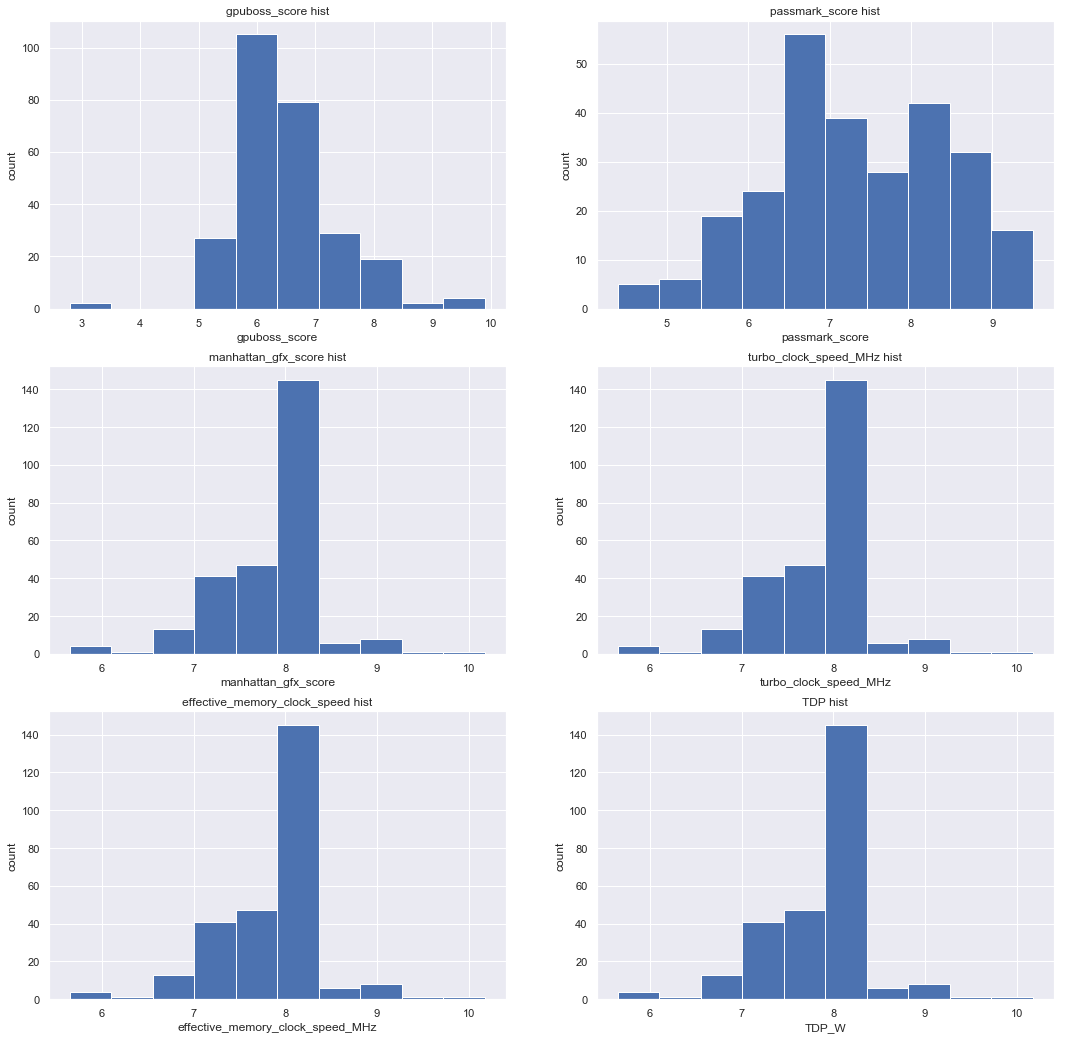

In [3109]:
#histogram of all features + response variable
plt.figure(figsize=(18,18))

# regression plot
plt.subplot(3,2,1)
plt.hist(df_final.gpuboss_score)
plt.title("gpuboss_score hist")
plt.xlabel("gpuboss_score")
plt.ylabel("count")

plt.subplot(3,2,2)
plt.hist(df_final.passmark_score)
plt.title("passmark_score hist")
plt.xlabel("passmark_score")
plt.ylabel("count")

plt.subplot(3,2,3)
plt.hist(df_final.manhattan_gfx_score)
plt.title("manhattan_gfx_score hist")
plt.xlabel("manhattan_gfx_score")
plt.ylabel("count")

plt.subplot(3,2,4)
plt.hist(df_final.manhattan_gfx_score)
plt.title("turbo_clock_speed_MHz hist")
plt.xlabel("turbo_clock_speed_MHz")
plt.ylabel("count")

plt.subplot(3,2,5)
plt.hist(df_final.manhattan_gfx_score)
plt.title("effective_memory_clock_speed hist")
plt.xlabel("effective_memory_clock_speed_MHz")
plt.ylabel("count")

plt.subplot(3,2,6)
plt.hist(df_final.manhattan_gfx_score)
plt.title("TDP hist")
plt.xlabel("TDP_W")
plt.ylabel("count");

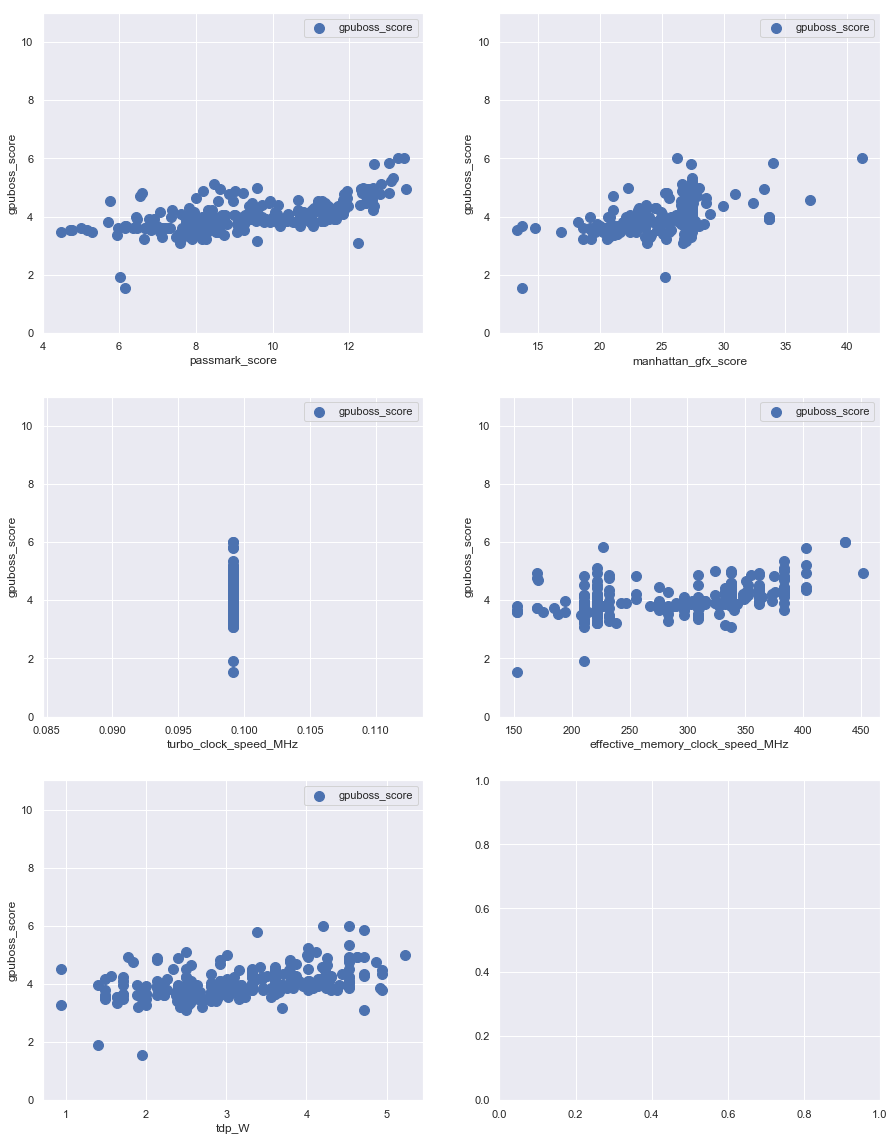

In [3096]:
# Set up a figure and axes for 5 plots, 2 per row for 3 rows
fig, ax_rows = plt.subplots(3, 2, figsize=(15, 20))

# Plot the results of a pipeline against ground truth and actual data
def plot_approximation(feature, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    #ax.plot(x_plot, f(x_plot), label='ground truth', color='green')
    ax.scatter(X_reduced_3.iloc[:,feature], y, s=100)
    #ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((0, 11))
    #ax.set_xlim((0, 1))
    ax.set_ylabel('gpuboss_score')
    ax.set_xlabel(X_reduced_3.columns[feature])
    ax.legend(loc='upper right',frameon=True)

for feature in range(5):
    #est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    #est.fit(X, y)
    # This sets the appropriate axis for each degree (KEEP)
    ax_row_left, ax_row_right = ax_rows[feature//2]
    if feature%2 == 0:
        ax = ax_row_left
    else:
        ax = ax_row_right
    plot_approximation(feature, ax, label='feature=%s' % X_reduced_3.columns[feature])

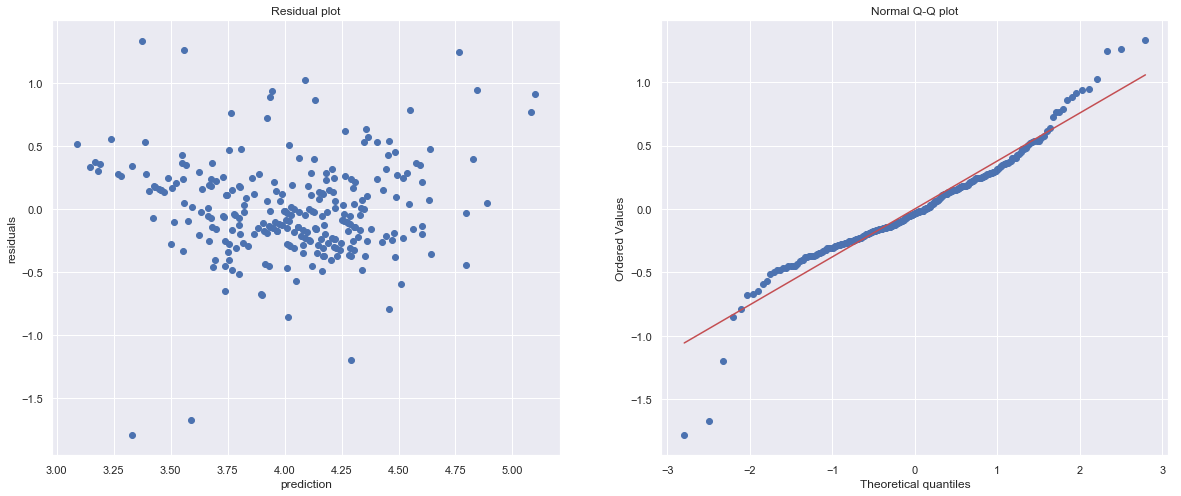

In [3097]:
plt.figure(figsize=(20,8))

rgr = LinearRegression()
rgr.fit(X_reduced_3,y)
pred = rgr.predict(X_reduced_3)

# regression plot
res = y - pred
plt.subplot(1,2,1)
plt.scatter(pred,res)
plt.title("Residual plot")
plt.xlabel("prediction")
plt.ylabel("residuals")

# Q-Q plot; if plot looks crazy, something is wrong
# Generates a probability plot of sample data against the quantiles of a 
#specified theoretical distribution 
plt.subplot(1,2,2)
stats.probplot(res,dist='norm',plot=plt)
plt.title("Normal Q-Q plot");

In [3098]:
# Define the model
lm6 = smf.ols('y ~ X_reduced_3',data=df_final)

# Fit the model
fit6 = lm6.fit()

# Check out the results
fit6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     47.25
Date:                Thu, 11 Oct 2018   Prob (F-statistic):           1.11e-34
Time:                        07:38:27   Log-Likelihood:                -125.53
No. Observations:                 267   AIC:                             263.1
Df Residuals:                     261   BIC:                             284.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -1.549e+08   3.68e+07     -4.207      0.000   -2.27e+08   -8.24e+07
X_reduced_3[0]     0.1891      0.034      5.630      0.000       0.123       0.255
X_reduced_3[1]     0.0270      0.009      2.961      0.003       0.009       0.045
X_reduced_3[2]  1.562e+09   3.71e+08      4.207      0.000    8.31e+08    2.29e+09
X_reduced_3[3]    -0.0013      0.001     -1.972      0.050      -0.003   -1.84e-06
X_reduced_3[4]    -0.1685      0.052     -3.261      0.001      -0.270      -0.067
==============================================================================
Omnibus:                       27.190   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.221
Skew:                          -0.058   Prob(JB):                     5.28e-29
Kurtosis:                       6.419   Cond. No.                     4.59e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.1e-18. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Visualizing Overfitting / the perfect polynomial degree model

In [3062]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X_reduced_3, y, test_size=0.8, random_state=8)

#NOTE: use 80% test to make a point of major generalization
#change `random_state` to see different results

### visualize linear regression

Saving graph to: polynomial_check.svg


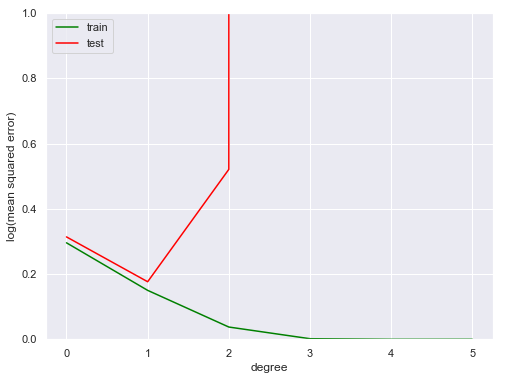

In [3147]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

# Step through degrees from 0 to 6 and store the training and test (generalization) error.
# create array of zeros,
train_error = np.empty(6)
test_error = np.empty(6)
for degree in range(6):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(6), train_error, color='green', label='train')
plt.plot(np.arange(6), test_error, color='red', label='test')
plt.ylim((0.0, 1))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left');

# Save options
save = 'polynomial_check'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')

## per above plot, degree = 1 linear regression is PERFECT for the data

## Heatmap for correlations

In [3064]:
df_final = X_reduced_3
df_final = pd.concat([y,df_final],axis=1)
df_final.head(3)

,gpuboss_score,passmark_score,manhattan_gfx_score,turbo_clock_speed_MHz,effective_memory_clock_speed_MHz,tdp_W
0,3.858107,7.866656,11.802086,0.619802,30.038902,4.788247
1,3.981826,8.334306,12.095235,0.619803,31.075004,4.950455
2,3.858107,7.822275,12.070799,0.619803,30.038902,5.092320


##  Final heatmap of features against response variable

Saving graph to: final_corr_heatmap.svg


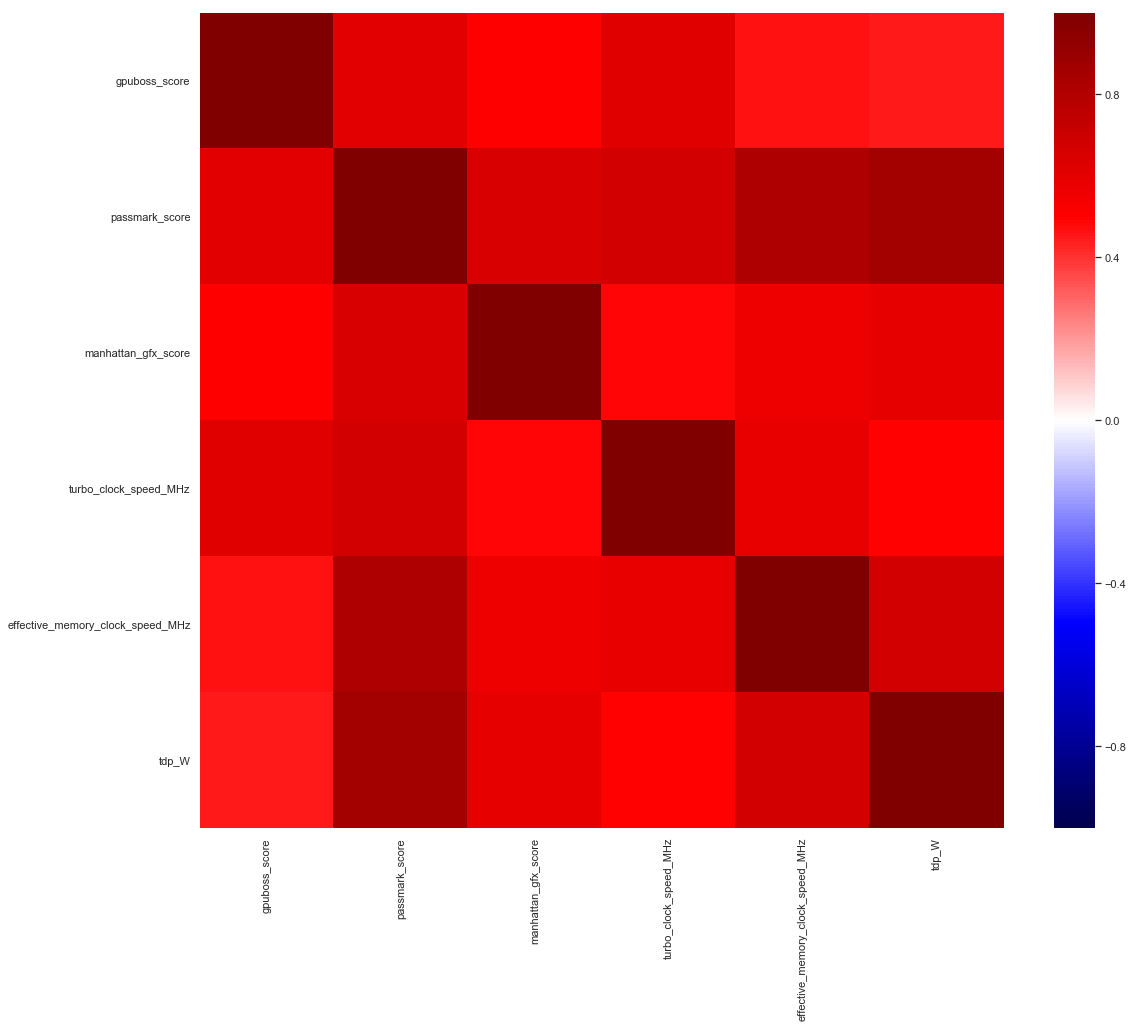

In [3186]:
# example of a better corr matrix
plt.figure(figsize=(18,15))  
sns.heatmap(df_final.corr(), cmap="seismic", annot=False, vmin=-1, vmax=1);
# more cmaps: https://matplotlib.org/examples/color/colormaps_reference.html

# Save options
save = 'final_corr_heatmap'

if save:
    print('Saving graph to:', save + '.svg')
    plt.savefig(save + '.svg', format='svg')

## results with sklearn

In [3114]:
# Create an empty model
lr2 = LinearRegression()

# Fit the model to the full dataset
lr2.fit(X_reduced_3, y)

# Print out the R^2 for the model against the full dataset
lr2.score(X_reduced_3, y)

0.49098319420085657

In [3115]:
lr2.intercept_

-7.870420473862979

In [3126]:
lr2.coef_

array([ 0.47368138,  0.26368907,  1.72629113, -0.26507612, -0.20979494])

In [3116]:
np.log(300)

5.703782474656201